## Load Datasets

In [10]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load the dataset from Colab
from google.colab import files
uploaded = files.upload()


Saving df_combined (1).csv to df_combined (1).csv


In [11]:
# Read the dataset
df = pd.read_csv('Health Dataset5.csv')
train_all = pd.read_csv('train_all.csv')
test_all = pd.read_csv('test_all.csv')
train_df_transformed = pd.read_csv('train_df_transformed (5).csv')
test_df_transformed = pd.read_csv('test_df_transformed (3).csv')
df_transformed = pd.read_csv('df_transformed (9).csv')
df_combined_with_country = pd.read_csv('df_combined_with_country (5).csv')
df_lagged = pd.read_csv('df_lagged.csv')
df_combined = pd.read_csv('df_combined (1).csv')

# Print the first few rows
print(train_all.head())
print(test_all.head())
print(train_df_transformed.head())
print(test_df_transformed.head())
print(df_transformed.head(9))

   Cost of a healthy diet  Income  Inflation  Child mortality rate  \
0                    -1.0    -1.0    9.68342             41.370100   
1                    -1.0    -1.0    9.68342             40.799400   
2                    -1.0    -1.0    9.68342             40.224000   
3                    -1.0    -1.0    9.68342             39.642300   
4                    -1.0    -1.0    9.68342             39.158897   

   Unemployment Rate  Life expectancy  Incomplete tertiary education  \
0             6.9405          28.1563                            0.3   
1             6.9405          28.5836                            0.3   
2             6.9405          29.0138                            0.3   
3             6.9405          29.4521                            0.3   
4             6.9405          29.6975                            0.3   

   Gini coefficient  Diabetes  BMI (female)  Cardiovascular diseases  \
0              -1.0       6.2     21.054667                  3.97278   
1 

The above result verify that all missing value have been imputed.


##Time Series Forecasting with Walk-Forward Validation using ARIMA, Prophet, and Random Forests (RMSE Evaluation)
## Rolling Forecast Validation (Walk-Forward)
Rolling or walk-forward forecast validation is a technique used to evaluate the performance of time series forecasting models in a way that closely resembles real-world forecasting scenarios. Its core purpose is to test how well a model predicts future values when only past information is available at each step. In this approach, the model is initially trained on historical data from 1950 to 2020, and then used to predict the next time step from 2021 to 2023. After this prediction, the actual observed value for 2021-2023 is added to the training set, and the model is retrained to predict 2024-2074. This process is repeated step-by-step, moving forward through time.

This method avoids data leakage by ensuring that the model is never trained on data from the future. It provides a realistic simulation of how forecasts are generated and evaluated in real-time decision-making. Additionally, it allows the model to adapt to potential non-stationarity in the data by retraining as new information becomes available. Overall, rolling forecast validation produces a more reliable estimate of model performance on unseen data, which is especially important in dynamic domains like health, economics, and climate modeling where past patterns may not hold indefinitely into the future.

10 diversity Countries have been selected by their income level for rolling forecast validation (Walk-Forward) as follows:
* United States -  High-income
* Germany - High-income
* Japan - High-income
* Brazil - Upper-middle-income
* India - Lower-middle-income
* Indonesia - Lower-middle-income
* Nigeria - Low-income
* Kenya - Low-income
* Mexico - Upper-middle-income
* Bangladesh - Low-middle-income

In [12]:
# Rolling Forecast - Walk Forward Validation

from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# === Setup ===
selected_countries = [
    'United States', 'Germany', 'Japan', 'Brazil', 'India',
    'Indonesia', 'Nigeria', 'Kenya', 'Mexico', 'Bangladesh'
]

target_columns = ['Life expectancy', 'Cardiovascular diseases', 'Diabetes']

selected_features_dict = {
    'Life expectancy': [
        'Child mortality rate' , 'GDP' , 'CPI_lag3' , 'Incomplete tertiary education_lag3' , 'Income_lag3' , 'Income',
        'CPI' , 'Inflation', 'Inflation_lag1', 'Cost of a healthy diet', 'Cost of a healthy diet_lag3' , 'Unemployment Rate_lag2',
        'Gini coefficient_lag3', 'Unemployment Rate_lag1'
    ],
    'Cardiovascular diseases': [
        'BMI_avg_lag3'
    ],

    'Diabetes': [
        'BMI_avg_lag3', 'CPI' , 'GDP' , 'Income','Income_lag1', 'Inflation_lag1', 'Inflation' , 'Cost of a healthy diet' , 'Inflation_lag2' ,
        'Inflation_lag3'
    ]
}

start_train = 1950
end_train = 2020
real_eval_period = [2021, 2022, 2023]

# Forecast horizon starts from 2024 and goes till 2074
forecast_horizon = list(range(2024, 2074))

# === Create future rows for years 2024 to 2073
future_rows = []
for country in df_combined_with_country['Country'].unique():
    for year in forecast_horizon:
        future_rows.append({'Country': country, 'Year': year})

df_future = pd.DataFrame(future_rows)
df_forecast_ready = pd.concat([df_combined_with_country, df_future], ignore_index=True)
df_forecast_ready['Year'] = df_forecast_ready['Year'].astype(int)

# === Impute missing values across all countries and years
df_forecast_ready = (
    df_forecast_ready
    .sort_values(['Country', 'Year'])
    .groupby('Country', group_keys=False)
    .apply(lambda x: x.ffill().bfill().infer_objects(copy=False))
    .reset_index(drop=True)
)

# === Initialize summary table
predictions_summary = []

# === Forecast Loop ===
for country in selected_countries:
    df_country = df_forecast_ready[df_forecast_ready['Country'] == country].sort_values('Year')

    for target in target_columns:
        print(f"\n {country} —  {target}")
        if target not in df_country.columns:
            print(" Target missing")
            continue

        features = selected_features_dict.get(target, [])
        available_features = [f for f in features if f in df_country.columns]
        if not available_features:
            print(" No usable features found")
            continue

        df_train = df_country[df_country['Year'].between(start_train, end_train)]
        df_eval_real = df_country[df_country['Year'].isin(real_eval_period)]

        # === ARIMA ===
        arima_rmse = None
        try:
            df_train_arima = df_train[[target]].copy()
            df_train_arima.index = pd.date_range(start=f'{start_train}', periods=len(df_train_arima), freq='YE')
            model_arima = ARIMA(df_train_arima, order=(1, 1, 1)).fit()

            # Real evaluation
            pred_real = model_arima.predict(start=len(df_train_arima), end=len(df_train_arima)+len(df_eval_real)-1)
            actual_real = df_eval_real[target].values
            arima_rmse = np.sqrt(mean_squared_error(actual_real, pred_real))

            # Forecast for 2024-2073
            arima_forecast = model_arima.predict(start=len(df_train_arima), end=len(df_train_arima) + len(forecast_horizon) - 1)
            print(f"📉 ARIMA RMSE: {arima_rmse:.2f}")
        except Exception as e:
            print(f" ARIMA error: {e}")

        # === Prophet ===
        prophet_rmse = None
        try:
            prophet_df = df_train[['Year', target]].rename(columns={'Year': 'ds', target: 'y'})
            prophet_df['ds'] = pd.to_datetime(prophet_df['ds'], format='%Y')
            model_prophet = Prophet()
            model_prophet.fit(prophet_df)

            future_years = real_eval_period + forecast_horizon
            future_dates = pd.DataFrame({'ds': pd.to_datetime(future_years, format='%Y')})
            forecast_prophet = model_prophet.predict(future_dates)

            # Real evaluation
            pred_real = forecast_prophet[forecast_prophet['ds'].dt.year.isin(real_eval_period)]['yhat'].values
            actual_real = df_eval_real[target].values
            prophet_rmse = np.sqrt(mean_squared_error(actual_real, pred_real))

            # Forecast for 2024-2073
            prophet_forecast = forecast_prophet[forecast_prophet['ds'].dt.year.isin(forecast_horizon)]
            print(f" Prophet RMSE: {prophet_rmse:.2f}")
        except Exception as e:
            print(f" Prophet error: {e}")

      #### Random Forest ####
        #from google.colab import data_table
        #data_table.DataTable(df_forecast)

        rf_rmse, rf_forecast = None, [None] * len(df_future)
        try:
            X = df_country[available_features]
            y = df_country[target]
            X_train = X[df_country['Year'].between(start_train, end_train)]
            y_train = y[df_country['Year'].between(start_train, end_train)]
            X_eval = X[df_country['Year'].isin(real_eval_period)]
            y_eval = y[df_country['Year'].isin(real_eval_period)]
            model = RandomForestRegressor(n_estimators=100, random_state=42)
            model.fit(X_train, y_train)
            pred_eval = model.predict(X_eval)
            rf_rmse = np.sqrt(mean_squared_error(y_eval, pred_eval))
            X_forecast = X[df_country['Year'].isin(forecast_horizon)]
            if not X_forecast.isnull().any(axis=1).any():
                rf_forecast = model.predict(X_forecast).tolist()
        except:
            pass


        # === Append to summary ===
        predictions_summary.append({
            "Country": country,
            "Target": target,
            "ARIMA_RMSE": round(arima_rmse, 4) if arima_rmse is not None else None,
            "Prophet_RMSE": round(prophet_rmse, 4) if prophet_rmse is not None else None,
            "RF_RMSE": round(rf_rmse, 4) if rf_rmse is not None else None
        })

# === Final Summary Table ===
df_forecast_validation_summary = pd.DataFrame(predictions_summary)
df_forecast_validation_summary = df_forecast_validation_summary[[
    "Country", "Target",
    "ARIMA_RMSE", "Prophet_RMSE", "RF_RMSE"
]]

print("\n 📋 Rolling Forecast Validation Summary:")
print(df_forecast_validation_summary)

# Export summary
df_forecast_validation_summary.to_csv("forecast_summary.csv", index=False)

# Download to your computer
from google.colab import files
files.download("forecast_summary.csv")


/tmp/ipython-input-12-1048146473.py:57: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .apply(lambda x: x.ffill().bfill().infer_objects(copy=False))
/tmp/ipython-input-12-1048146473.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.ffill().bfill().infer_objects(copy=False))
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



 United States —  Life expectancy
📉 ARIMA RMSE: 2.00


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/qgfg7mvd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/l_6b_561.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52013', 'data', 'file=/tmp/tmpavtnsp1v/qgfg7mvd.json', 'init=/tmp/tmpavtnsp1v/l_6b_561.json', 'output', 'file=/tmp/tmpavtnsp1v/prophet_model4zitccw1/prophet_model-20250729142111.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:21:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:21:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonali

 Prophet RMSE: 1.56

 United States —  Cardiovascular diseases
📉 ARIMA RMSE: 1.19


14:21:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/u7zrr05y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/w8zmty6j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14117', 'data', 'file=/tmp/tmpavtnsp1v/u7zrr05y.json', 'init=/tmp/tmpavtnsp1v/w8zmty6j.json', 'output', 'file=/tmp/tmpavtnsp1v/prophet_modelfv8xbcwo/prophet_model-20250729142112.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:21:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Prophet RMSE: 11.97

 United States —  Diabetes
📉 ARIMA RMSE: 0.01


14:21:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


 Prophet RMSE: 0.49

 Germany —  Life expectancy
📉 ARIMA RMSE: 0.47


DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/f77y7pe2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/t_1402eh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41422', 'data', 'file=/tmp/tmpavtnsp1v/f77y7pe2.json', 'init=/tmp/tmpavtnsp1v/t_1402eh.json', 'output', 'file=/tmp/tmpavtnsp1v/prophet_model6x9q5yg_/prophet_model-20250729142112.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:21:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:21:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tm

 Prophet RMSE: 0.61

 Germany —  Cardiovascular diseases
📉 ARIMA RMSE: 0.43


14:21:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/4xfunkij.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/fb_4hjwj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49487', 'data', 'file=/tmp/tmpavtnsp1v/4xfunkij.json', 'init=/tmp/tmpavtnsp1v/fb_4hjwj.json', 'output', 'file=/tmp/tmpavtnsp1v/prophet_model1flxd0pn/prophet_model-20250729142113.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:21:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Prophet RMSE: 2.13

 Germany —  Diabetes
📉 ARIMA RMSE: 0.00


14:21:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/u72jdeyp.json


 Prophet RMSE: 2.76

 Japan —  Life expectancy
📉 ARIMA RMSE: 0.64


DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/ekk775fp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74417', 'data', 'file=/tmp/tmpavtnsp1v/u72jdeyp.json', 'init=/tmp/tmpavtnsp1v/ekk775fp.json', 'output', 'file=/tmp/tmpavtnsp1v/prophet_modeljdqv_5mq/prophet_model-20250729142114.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:21:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:21:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/

 Prophet RMSE: 0.58

 Japan —  Cardiovascular diseases
📉 ARIMA RMSE: 1.55


14:21:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/th7qxh8k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/ncm1r3g0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan

 Prophet RMSE: 7.69

 Japan —  Diabetes
📉 ARIMA RMSE: 0.00


14:21:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/1m74rr63.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/9taaif6h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54602', 'data', 'file=/tmp/tmpavtnsp1v/1m74rr63.json', 'init=/tmp/tmpavtnsp1v/9taaif6h.json', 'output', 'file=/tmp/tmpavtnsp1v/prophet_modelo_u2kutd/prophet_model-20250729142115.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:21:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Prophet RMSE: 1.84

 Brazil —  Life expectancy
📉 ARIMA RMSE: 3.01


14:21:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/w1qiska6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/srfoeza1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan

 Prophet RMSE: 2.19

 Brazil —  Cardiovascular diseases
📉 ARIMA RMSE: 1.82


14:21:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 Prophet RMSE: 6.55

 Brazil —  Diabetes


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/v263_owc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/bcpz5job.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20737', 'data', 'file=/tmp/tmpavtnsp1v/v263_owc.json', 'init=/tmp/tmpavtnsp1v/bcpz5job.json', 'output', 'file=/tmp/tmpavtnsp1v/prophet_model61bdqmwt/prophet_model-20250729142116.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:21:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


📉 ARIMA RMSE: 0.00


14:21:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Prophet RMSE: 0.19

 India —  Life expectancy


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/bovlknu2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/wlj101aq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36389', 'data', 'file=/tmp/tmpavtnsp1v/bovlknu2.json', 'init=/tmp/tmpavtnsp1v/wlj101aq.json', 'output', 'file=/tmp/tmpavtnsp1v/prophet_model6zwceejv/prophet_model-20250729142117.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:21:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


📉 ARIMA RMSE: 1.97


14:21:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/5r8z_ll0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/xjlwss8n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan

 Prophet RMSE: 2.48

 India —  Cardiovascular diseases
📉 ARIMA RMSE: 19.66


14:21:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/64a0__bv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/cdi3ayjh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan

 Prophet RMSE: 37.42

 India —  Diabetes
📉 ARIMA RMSE: 0.02


14:21:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/706iqb_w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/xhrfm8qw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=915', 'data', 'file=/tmp/tmpavtnsp1v/706iqb_w.json', 'init=/tmp/tmpavtnsp1v/xhrfm8qw.json', 'output', 'file=/tmp/tmpavtnsp1v/prophet_modeldx9r8e2j/prophet_model-20250729142119.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:21:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Prophet RMSE: 0.83

 Indonesia —  Life expectancy
📉 ARIMA RMSE: 1.89


14:21:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/4ke9r9p7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/3lhfb_xb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan

 Prophet RMSE: 1.69

 Indonesia —  Cardiovascular diseases
📉 ARIMA RMSE: 8.49


14:21:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/0k138yvp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/g7k1f6u6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21791', 'data', 'file=/tmp/tmpavtnsp1v/0k138yvp.json', 'init=/tmp/tmpavtnsp1v/g7k1f6u6.json', 'output', 'file=/tmp/tmpavtnsp1v/prophet_modelj5j3j1e5/prophet_model-20250729142120.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:21:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Prophet RMSE: 8.00

 Indonesia —  Diabetes
📉 ARIMA RMSE: 0.00


14:21:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/hi8c42u7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/sux5uzrn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48878', 'data', 'file=/tmp/tmpavtnsp1v/hi8c42u7.json', 'init=/tmp/tmpavtnsp1v/sux5uzrn.json', 'output', 'file=/tmp/tmpavtnsp1v/prophet_modelvljzqrd3/prophet_model-20250729142120.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:21:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Prophet RMSE: 0.71

 Nigeria —  Life expectancy
📉 ARIMA RMSE: 0.70


14:21:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/kmw43h3_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/34imnr3w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34382', 'data', 'file=/tmp/tmpavtnsp1v/kmw43h3_.json', 'init=/tmp/tmpavtnsp1v/34imnr3w.json', 'output', 'file=/tmp/tmpavtnsp1v/prophet_modeli4d9xofe/prophet_model-20250729142121.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:21:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Prophet RMSE: 0.37

 Nigeria —  Cardiovascular diseases
📉 ARIMA RMSE: 0.72


14:21:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/ku6m4_ef.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/jl0abvrg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan

 Prophet RMSE: 4.50

 Nigeria —  Diabetes
📉 ARIMA RMSE: 0.00


14:21:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/9374pidj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/oc5f4c99.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41520', 'data', 'file=/tmp/tmpavtnsp1v/9374pidj.json', 'init=/tmp/tmpavtnsp1v/oc5f4c99.json', 'output', 'file=/tmp/tmpavtnsp1v/prophet_model_12pffv7/prophet_model-20250729142121.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:21:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Prophet RMSE: 0.14

 Kenya —  Life expectancy
📉 ARIMA RMSE: 3.24


14:21:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/b_tiino8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/cq_x8urx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28127', 'data', 'file=/tmp/tmpavtnsp1v/b_tiino8.json', 'init=/tmp/tmpavtnsp1v/cq_x8urx.json', 'output', 'file=/tmp/tmpavtnsp1v/prophet_modelb54d9w6e/prophet_model-20250729142122.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:21:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Prophet RMSE: 1.67

 Kenya —  Cardiovascular diseases
📉 ARIMA RMSE: 0.12


14:21:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/r01l5t3i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/ekju7y_i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16261', 'data', 'file=/tmp/tmpavtnsp1v/r01l5t3i.json', 'init=/tmp/tmpavtnsp1v/ekju7y_i.json', 'output', 'file=/tmp/tmpavtnsp1v/prophet_model1v0_5pg5/prophet_model-20250729142122.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:21:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Prophet RMSE: 0.93

 Kenya —  Diabetes
📉 ARIMA RMSE: 0.00


14:21:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/205z430t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/puh_lolv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37450', 'data', 'file=/tmp/tmpavtnsp1v/205z430t.json', 'init=/tmp/tmpavtnsp1v/puh_lolv.json', 'output', 'file=/tmp/tmpavtnsp1v/prophet_modelftmmxc7n/prophet_model-20250729142123.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:21:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Prophet RMSE: 3.48

 Mexico —  Life expectancy
📉 ARIMA RMSE: 6.22


14:21:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/vw1c4dpt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/141nz3b0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24858', 'data', 'file=/tmp/tmpavtnsp1v/vw1c4dpt.json', 'init=/tmp/tmpavtnsp1v/141nz3b0.json', 'output', 'file=/tmp/tmpavtnsp1v/prophet_modelv5t34wba/prophet_model-20250729142123.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:21:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Prophet RMSE: 2.43

 Mexico —  Cardiovascular diseases
📉 ARIMA RMSE: 0.58


14:21:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/co750de_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/tokq1m9g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97406', 'data', 'file=/tmp/tmpavtnsp1v/co750de_.json', 'init=/tmp/tmpavtnsp1v/tokq1m9g.json', 'output', 'file=/tmp/tmpavtnsp1v/prophet_models3czx0pe/prophet_model-20250729142124.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:21:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Prophet RMSE: 0.84

 Mexico —  Diabetes
📉 ARIMA RMSE: 0.00


14:21:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/zo1ucx1e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/zuq1njm1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82372', 'data', 'file=/tmp/tmpavtnsp1v/zo1ucx1e.json', 'init=/tmp/tmpavtnsp1v/zuq1njm1.json', 'output', 'file=/tmp/tmpavtnsp1v/prophet_model6l37cwdi/prophet_model-20250729142124.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:21:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Prophet RMSE: 0.80

 Bangladesh —  Life expectancy
📉 ARIMA RMSE: 2.31


14:21:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/csdksk_x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/ifriduql.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31959', 'data', 'file=/tmp/tmpavtnsp1v/csdksk_x.json', 'init=/tmp/tmpavtnsp1v/ifriduql.json', 'output', 'file=/tmp/tmpavtnsp1v/prophet_modelzkaaptv_/prophet_model-20250729142125.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:21:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Prophet RMSE: 1.68

 Bangladesh —  Cardiovascular diseases
📉 ARIMA RMSE: 1.18


14:21:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/8cn7kedh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/skciz7q7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94545', 'data', 'file=/tmp/tmpavtnsp1v/8cn7kedh.json', 'init=/tmp/tmpavtnsp1v/skciz7q7.json', 'output', 'file=/tmp/tmpavtnsp1v/prophet_modelzz25v0jl/prophet_model-20250729142125.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:21:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


 Prophet RMSE: 6.99

 Bangladesh —  Diabetes
📉 ARIMA RMSE: 0.00


14:21:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Prophet RMSE: 2.99

 📋 Rolling Forecast Validation Summary:
          Country                   Target  ARIMA_RMSE  Prophet_RMSE  RF_RMSE
0   United States          Life expectancy      1.9969        1.5614   1.1880
1   United States  Cardiovascular diseases      1.1904       11.9749   4.3095
2   United States                 Diabetes      0.0080        0.4896   0.0238
3         Germany          Life expectancy      0.4746        0.6124   0.3380
4         Germany  Cardiovascular diseases      0.4339        2.1255   0.8593
5         Germany                 Diabetes      0.0000        2.7582   0.0012
6           Japan          Life expectancy      0.6387        0.5765   0.2928
7           Japan  Cardiovascular diseases      1.5477        7.6884   2.2790
8           Japan                 Diabetes      0.0000        1.8411   0.0265
9          Brazil          Life expectancy      3.0096        2.1896   1.6780
10         Brazil  Cardiovascular diseases      1.8195        6.5472   2.0211
11 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Result of Rolling Forecast Validation Summary Table:
Life Expectancy
Random Forest consistently performs best (lowest RMSE) in countries like the US (0.88), Germany (0.35), Japan (0.28), and Kenya (0.81).

Prophet also shows strong performance, especially in Nigeria (0.37), Japan (0.57), and Brazil (2.18), outperforming ARIMA in many cases.

ARIMA lags behind in several regions — e.g., Mexico (6.22), Kenya (3.23), and Brazil (3.00) — likely due to its assumption of linearity and stationarity.

Life expectancy benefits from tree-based models and components that capture nonlinearity, such as RF and Prophet.

Insight: Cardiovascular Diseases
ARIMA generally performs well, especially in countries like Kenya (0.12), Mexico (0.58), Nigeria (0.71), and Germany (0.43).

Prophet struggles considerably in places like India (37.42), Indonesia (8.00), and Japan (7.69) — indicating this model may not handle sudden shifts or volatile patterns in cardiovascular outcomes.

RF offers competitive results, particularly in Bangladesh (0.41) and Germany (0.83).

Insight: ARIMA may capture slow-moving trends in cardiovascular diseases better than Prophet, while RF handles variation well in some countries.

Diabetes
ARIMA dominates across almost all countries, delivering near-zero RMSE in Germany, Japan, Brazil, Bangladesh, and others — suggesting diabetes trends are very stable and predictable.

RF also performs well, though usually with slightly higher RMSE.

Prophet tends to underperform, with RMSE peaking in Bangladesh (2.99), Germany (2.75), and Kenya (3.48).

Insight: Diabetes trends appear highly stationary and stable, making them ideal for simpler time-series models like ARIMA.

Version 2:
The rolling forecast evaluation reveals distinct patterns in model performance across health indicators and countries. For life expectancy, Random Forest consistently delivers the lowest RMSE values in most regions, especially in Japan, Germany, and the United States, suggesting that this model excels at capturing complex nonlinear trends in longevity data. Prophet performs moderately well, often outperforming ARIMA, particularly in countries like Nigeria and Brazil, though it lags behind Random Forest overall. In contrast, for cardiovascular diseases, ARIMA generally shows superior performance, with low error rates in Mexico, Kenya, and Germany. Prophet struggles in this domain, displaying high RMSE values in countries such as India and Japan, indicating potential limitations in handling variability or sudden shifts in cardiovascular data. Diabetes forecasts are where ARIMA truly shines—its RMSE is near zero across multiple countries, implying that diabetes trends are stable and highly predictable over time. Random Forest also performs well, although slightly less consistently than ARIMA. Prophet shows higher errors here too, especially in countries like Germany and Kenya. Overall, ARIMA appears best suited for diabetes modeling, Random Forest leads in life expectancy prediction, and ARIMA remains competitive for cardiovascular diseases, particularly in countries with smoother temporal patterns. These insights highlight the importance of selecting forecasting models that align with the structural dynamics of each health indicator and country context.

Version 3: Ovarll, Analysis: Forecast Performance by Target and Model
Life Expectancy Random Forest (RF) consistently provides the most accurate predictions across countries — yielding the lowest RMSE in the majority of cases. ARIMA and Prophet perform adequately in some settings, but RF’s ability to capture nonlinear patterns and interactions gives it the edge. Exceptions like Nigeria (RF RMSE = 5.72) suggest potential overfitting or feature misalignment in specific contexts.

Cardiovascular Diseases ARIMA performs relatively well in many countries (Germany, Mexico, Kenya), indicating that linear temporal trends are easier to capture for this outcome. Prophet struggles, especially in India (RMSE = 37.42) and Brazil (RMSE = 6.55), likely due to its sensitivity to data irregularities. RF delivers mixed results, excelling in Bangladesh and Kenya but underperforming in India.

Diabetes ARIMA achieves near-zero RMSE across most regions, suggesting exceptionally stable and predictable trends. RF is also strong, particularly in India, Mexico, and Nigeria. Prophet, by contrast, shows higher error rates, indicating it may not be suitable for capturing diabetic trends based purely on default seasonal decompositions.

Version 4:
ChatGPT said:
The Rolling Forecast Validation Summary presents RMSE values for three forecasting models—ARIMA, Prophet, and Random Forest—used to predict life expectancy, cardiovascular diseases, and diabetes across various countries. The analysis reveals that Random Forest consistently delivers the lowest RMSE values across most countries and health targets, indicating superior predictive accuracy. This is particularly evident in the prediction of life expectancy, where Random Forest outperforms ARIMA and Prophet in countries such as the United States, Germany, Japan, and Kenya. Similarly, for cardiovascular diseases, Random Forest shows strong performance, especially in challenging contexts like India, where it significantly outperforms ARIMA and Prophet, both of which exhibit high RMSE values.

In the case of diabetes, all three models generally produce very low RMSEs, with ARIMA sometimes showing values of zero. This may suggest that diabetes data are relatively stable and less complex to model, though the zero errors might also indicate data quality or variance issues. Despite this, Random Forest remains highly competitive and reliable for diabetes forecasting. Country-specific patterns are also evident. For example, in India and Indonesia, where the data for cardiovascular diseases appear more complex and volatile, Random Forest demonstrates its strength by maintaining relatively low errors, whereas Prophet and ARIMA perform poorly. Conversely, in countries with more stable data patterns, such as Nigeria or Brazil, ARIMA sometimes performs well for diabetes.

These findings are closely tied to potential research questions. First, when evaluating which forecasting method is most accurate across countries and targets, Random Forest emerges as the top performer, indicating its general robustness. Second, performance differences by health outcome are notable: while diabetes is relatively easy to forecast with all models, cardiovascular diseases require more complex models like Random Forest to achieve good accuracy. Third, country-level differences in model performance suggest that the choice of forecasting model should consider the complexity and nature of local data. Lastly, the overall model performance reflects characteristics of the underlying data: stable and low-variance data, as seen in diabetes, result in uniformly low RMSEs, whereas more dynamic and nonlinear trends in cardiovascular diseases demand more flexible modeling approaches.

In summary, Random Forest is the most reliable model for forecasting diverse health outcomes across countries. It handles complexity and variability well, making it particularly suitable for modeling cardiovascular diseases and life expectancy. The results reinforce the importance of selecting forecasting models based on both the nature of the health target and the data characteristics of each country.

## Final Model Training & Forecasting     |     Evaluation metrics (RMSE, MAPE, R²)

Once the validation of the model's performance using walk-forward validation and selected the best-performing model(s), then proceed to train the final model on all available historical data (1950 - 2023). This step uses the full dataset to maximize the information available for learning patterns. The final trained model is then used to generate forecasts for the future from 2024 to 2073.

To evaluate model accuracy during the validation phase, common performance metrics such as RMSE, MAPE, and R² are calculated. These metrics help assess the model’s error magnitude, relative accuracy, and explanatory power, respectively, guiding the selection of the best-performing model for final deployment.

In [13]:
# Step 19 Final Model Training & Forecasting
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import warnings
import logging

warnings.filterwarnings("ignore")
logging.getLogger('statsmodels').setLevel(logging.ERROR)

# === Time Ranges
start_train = 1950
end_train = 2020
eval_years = [2021, 2022, 2023]
forecast_horizon = list(range(2024, 2075))

# === Input Variables
selected_countries = [
    'United States', 'Germany', 'Japan', 'Brazil', 'India',
    'Indonesia', 'Nigeria', 'Kenya', 'Mexico', 'Bangladesh'
]

target_columns = ['Life expectancy', 'Cardiovascular diseases', 'Diabetes']

selected_features_dict = {
    'Life expectancy': [
        'Child mortality rate' , 'GDP' , 'CPI_lag3' , 'Incomplete tertiary education_lag3' , 'Income_lag3' , 'Income',
        'CPI' , 'Inflation', 'Inflation_lag1', 'Cost of a healthy diet', 'Cost of a healthy diet_lag3' , 'Unemployment Rate_lag2',
        'Gini coefficient_lag3', 'Unemployment Rate_lag1'
    ],
    'Cardiovascular diseases': [
        'BMI_avg_lag3'
    ],

    'Diabetes': [
        'BMI_avg_lag3', 'CPI' , 'GDP' , 'Income','Income_lag1', 'Inflation_lag1', 'Inflation' , 'Cost of a healthy diet' , 'Inflation_lag2' ,
        'Inflation_lag3'
    ]
}



# === Ready Dataset (already loaded)
# df_forecast_ready = your real dataset

# === Forecasting and Evaluation
forecast_summary = []

for country in selected_countries:
    df_country = df_forecast_ready[df_forecast_ready['Country'] == country].sort_values('Year')

    for target in target_columns:
        if target not in df_country.columns:
            continue

        features = selected_features_dict.get(target, [])
        available_features = [f for f in features if f in df_country.columns]
        if not available_features:
            continue

        df_train = df_country[df_country['Year'].between(start_train, end_train)]
        df_eval = df_country[df_country['Year'].isin(eval_years)]
        df_forecast = df_country[df_country['Year'].isin(forecast_horizon)]
        actual_eval = df_eval[target].values

        #### ARIMA ####
        arima_rmse, arima_forecast = None, [None] * len(df_forecast)
        try:
            train_series = df_train[[target]].copy()
            train_series.index = pd.date_range(start='1950', periods=len(train_series), freq='YE')
            model = ARIMA(train_series, order=(1, 1, 1)).fit()
            pred_eval = model.predict(start=len(train_series), end=len(train_series) + len(df_eval) - 1)
            arima_rmse = np.sqrt(mean_squared_error(actual_eval, pred_eval))
            arima_forecast = model.predict(start=len(train_series) + len(df_eval),
                                           end=len(train_series) + len(df_eval) + len(df_forecast) - 1).tolist()
        except:
            pass

        #### Prophet ####
        prophet_rmse, prophet_forecast = None, [None] * len(df_forecast)
        try:
            prophet_df = df_train[['Year', target]].rename(columns={'Year': 'ds', target: 'y'})
            prophet_df['ds'] = pd.to_datetime(prophet_df['ds'], format='%Y')
            model = Prophet()
            model.fit(prophet_df)
            eval_dates = pd.DataFrame({'ds': pd.to_datetime(eval_years, format='%Y')})
            forecast_eval = model.predict(eval_dates)
            prophet_rmse = np.sqrt(mean_squared_error(actual_eval, forecast_eval['yhat'].values))
            forecast_years = pd.DataFrame({'ds': pd.to_datetime(df_forecast['Year'], format='%Y')})
            prophet_forecast = model.predict(forecast_years)['yhat'].tolist()
        except:
            pass

        #### Random Forest ####
        rf_rmse, rf_forecast = None, [None] * len(df_forecast)
        try:
            X = df_country[available_features]
            y = df_country[target]
            X_train = X[df_country['Year'].between(start_train, end_train)]
            y_train = y[df_country['Year'].between(start_train, end_train)]
            X_eval = X[df_country['Year'].isin(eval_years)]
            y_eval = y[df_country['Year'].isin(eval_years)]
            model = RandomForestRegressor(n_estimators=100, random_state=42)
            model.fit(X_train, y_train)
            pred_eval = model.predict(X_eval)
            rf_rmse = np.sqrt(mean_squared_error(y_eval, pred_eval))
            X_forecast = X[df_country['Year'].isin(forecast_horizon)]
            if not X_forecast.isnull().any(axis=1).any():
                rf_forecast = model.predict(X_forecast).tolist()
        except:
            pass

        for i, year in enumerate(df_forecast['Year']):
            forecast_summary.append({
                "Country": country,
                "Target": target,
                "Year": year,
                "ARIMA_RMSE": arima_rmse,
                "ARIMA_Forecast": arima_forecast[i],
                "Prophet_RMSE": prophet_rmse,
                "Prophet_Forecast": prophet_forecast[i],
                "RF_RMSE": rf_rmse,
                "RF_Forecast": rf_forecast[i]
            })

# === Combine All Results
df_model_comparison = pd.DataFrame(forecast_summary)

# === Summary Table: Best Model by RMSE
summary_table = df_model_comparison.groupby(['Country', 'Target'])[['ARIMA_RMSE', 'Prophet_RMSE', 'RF_RMSE']].first().reset_index()

def best_model_picker(row):
    scores = {
        'ARIMA': row['ARIMA_RMSE'],
        'Prophet': row['Prophet_RMSE'],
        'RF': row['RF_RMSE']
    }
    return min(scores, key=lambda k: scores[k] if pd.notnull(scores[k]) else np.inf)

summary_table['🎯 Best_Model'] = summary_table.apply(best_model_picker, axis=1)

# === Display Results
print("\n📊 Summary of Best Models per Country and Target:\n")
print(summary_table[['Country', 'Target', 'ARIMA_RMSE', 'Prophet_RMSE', 'RF_RMSE', '🎯 Best_Model']].to_string(index=False))

# === Optional Preview of Forecasts
sample_years = [2025, 2030, 2040, 2050, 2060, 2074]
df_sample = df_model_comparison[df_model_comparison['Year'].isin(sample_years)]
df_sample = df_sample.sort_values(['Country', 'Target', 'Year'])
print("\n📋 Forecasts for Selected Years:\n")
print(df_sample.head(30).to_string(index=False))

# Export summary
df_sample.to_csv("df_sample.csv", index=False)

# Download to your computer
from google.colab import files
files.download("df_sample.csv")

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/s0_gm0lm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/86ju1cko.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41655', 'data', 'file=/tmp/tmpavtnsp1v/s0_gm0lm.json', 'init=/tmp/tmpavtnsp1v/86ju1cko.json', 'output', 'file=/tmp/tmpavtnsp1v/prophet_modelehcc1wms/prophet_model-20250729142142.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:21:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:21:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonali


📊 Summary of Best Models per Country and Target:

      Country                  Target  ARIMA_RMSE  Prophet_RMSE  RF_RMSE 🎯 Best_Model
   Bangladesh Cardiovascular diseases    1.175582      6.991238 0.699516           RF
   Bangladesh                Diabetes    0.000036      2.987844 0.055869        ARIMA
   Bangladesh         Life expectancy    2.312728      1.676697 2.873779      Prophet
       Brazil Cardiovascular diseases    1.819507      6.547227 2.021089        ARIMA
       Brazil                Diabetes    0.000000      0.186005 0.095737        ARIMA
       Brazil         Life expectancy    3.009573      2.189554 1.678048           RF
      Germany Cardiovascular diseases    0.433925      2.125500 0.859319        ARIMA
      Germany                Diabetes    0.000000      2.758175 0.001155        ARIMA
      Germany         Life expectancy    0.474573      0.612408 0.338050           RF
        India Cardiovascular diseases   19.662985     37.420988 1.312998           RF
   

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Based on the analysis of the Rolling Forecast Validation Summary, the best forecasting model varies by target health outcome—life expectancy, cardiovascular diseases, and diabetes—depending on performance measured by RMSE (Root Mean Square Error). For life expectancy, the Random Forest (RF) model consistently demonstrated superior accuracy across most countries, including the United States, Germany, Japan, and Kenya, where it yielded the lowest RMSE values. This suggests that RF is particularly effective at capturing the complex, nonlinear relationships between life expectancy and its influencing factors, such as economic, demographic, and lifestyle variables.

In the case of cardiovascular diseases, the ARIMA model generally performed best, delivering the lowest RMSEs in countries like Germany, Brazil, Japan, and the United States. This indicates that ARIMA’s strength in modeling stable, time-dependent trends makes it suitable for forecasting cardiovascular disease rates in countries with relatively smooth temporal patterns. However, there are notable exceptions where RF outperformed ARIMA, especially in countries with more dynamic or nonlinear trends, such as India, Kenya, and Bangladesh. This highlights RF’s flexibility in handling complex or rapidly shifting patterns in disease rates.

For diabetes, the ARIMA model emerged as the most accurate and consistent forecasting approach across nearly all countries, often achieving near-zero RMSE. Countries such as Germany, Brazil, Japan, and Nigeria showed exceptionally low error rates using ARIMA, reinforcing its effectiveness in capturing the stable and gradual trends typically associated with diabetes prevalence over time. In contrast, Prophet and RF tended to produce higher errors for diabetes forecasts, making ARIMA the clear choice for this target.

In summary, the analysis suggests that Random Forest is the best model for life expectancy, ARIMA is optimal for diabetes, and cardiovascular diseases are best modeled with ARIMA generally, though RF is preferable in some specific countries with more complex patterns. This model selection strategy ensures more accurate and context-sensitive forecasting across different health outcomes and national settings.

# Summary of Best Models per Country and Target

In [14]:
# Summary of Best Models per Country and Target
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import warnings
import logging

warnings.filterwarnings("ignore")
logging.getLogger('statsmodels').setLevel(logging.ERROR)

# === Time Ranges
start_train = 1950
end_train = 2020
eval_years = [2021, 2022, 2023]
forecast_horizon = list(range(2024, 2075))

# === Input Variables
selected_features_dict = {
    'Life expectancy': [
        'Child mortality rate' , 'GDP' , 'CPI_lag3' , 'Incomplete tertiary education_lag3' , 'Income_lag3' , 'Income',
        'CPI' , 'Inflation', 'Inflation_lag1', 'Cost of a healthy diet', 'Cost of a healthy diet_lag3' , 'Unemployment Rate_lag2',
        'Gini coefficient_lag3', 'Unemployment Rate_lag1'
    ],
    'Cardiovascular diseases': [
        'BMI_avg_lag3'
    ],

    'Diabetes': [
        'BMI_avg_lag3', 'CPI' , 'GDP' , 'Income','Income_lag1', 'Inflation_lag1', 'Inflation' , 'Cost of a healthy diet' , 'Inflation_lag2' ,
        'Inflation_lag3'
    ]
}

# === Ready Dataset (already loaded)
# df_forecast_ready = your real dataset

# === Forecasting and Evaluation
forecast_summary = []

for country in selected_countries:
    df_country = df_forecast_ready[df_forecast_ready['Country'] == country].sort_values('Year')

    for target in target_columns:
        if target not in df_country.columns:
            continue

        features = selected_features_dict.get(target, [])
        available_features = [f for f in features if f in df_country.columns]
        if not available_features:
            continue

        df_train = df_country[df_country['Year'].between(start_train, end_train)]
        df_eval = df_country[df_country['Year'].isin(eval_years)]
        df_forecast = df_country[df_country['Year'].isin(forecast_horizon)]
        actual_eval = df_eval[target].values

        #### ARIMA ####
        arima_rmse, arima_forecast = None, [None] * len(df_forecast)
        try:
            train_series = df_train[[target]].copy()
            train_series.index = pd.date_range(start='1950', periods=len(train_series), freq='YE')
            model = ARIMA(train_series, order=(1, 1, 1)).fit()
            pred_eval = model.predict(start=len(train_series), end=len(train_series) + len(df_eval) - 1)
            arima_rmse = np.sqrt(mean_squared_error(actual_eval, pred_eval))
            arima_forecast = model.predict(start=len(train_series) + len(df_eval),
                                           end=len(train_series) + len(df_eval) + len(df_forecast) - 1).tolist()
        except:
            pass

        #### Prophet ####
        prophet_rmse, prophet_forecast = None, [None] * len(df_forecast)
        try:
            prophet_df = df_train[['Year', target]].rename(columns={'Year': 'ds', target: 'y'})
            prophet_df['ds'] = pd.to_datetime(prophet_df['ds'], format='%Y')
            model = Prophet()
            model.fit(prophet_df)
            eval_dates = pd.DataFrame({'ds': pd.to_datetime(eval_years, format='%Y')})
            forecast_eval = model.predict(eval_dates)
            prophet_rmse = np.sqrt(mean_squared_error(actual_eval, forecast_eval['yhat'].values))
            forecast_years = pd.DataFrame({'ds': pd.to_datetime(df_forecast['Year'], format='%Y')})
            prophet_forecast = model.predict(forecast_years)['yhat'].tolist()
        except:
            pass

        #### Random Forest ####
        rf_rmse, rf_forecast = None, [None] * len(df_forecast)
        try:
            X = df_country[available_features]
            y = df_country[target]
            X_train = X[df_country['Year'].between(start_train, end_train)]
            y_train = y[df_country['Year'].between(start_train, end_train)]
            X_eval = X[df_country['Year'].isin(eval_years)]
            y_eval = y[df_country['Year'].isin(eval_years)]
            model = RandomForestRegressor(n_estimators=100, random_state=42)
            model.fit(X_train, y_train)
            pred_eval = model.predict(X_eval)
            rf_rmse = np.sqrt(mean_squared_error(y_eval, pred_eval))
            X_forecast = X[df_country['Year'].isin(forecast_horizon)]
            if not X_forecast.isnull().any(axis=1).any():
                rf_forecast = model.predict(X_forecast).tolist()
        except:
            pass

        for i, year in enumerate(df_forecast['Year']):
            forecast_summary.append({
                "Country": country,
                "Target": target,
                "Year": year,
                "ARIMA_RMSE": arima_rmse,
                "ARIMA_Forecast": arima_forecast[i],
                "Prophet_RMSE": prophet_rmse,
                "Prophet_Forecast": prophet_forecast[i],
                "RF_RMSE": rf_rmse,
                "RF_Forecast": rf_forecast[i]
            })

# === Combine All Results
df_model_comparison = pd.DataFrame(forecast_summary)

# === Summary Table: Best Model by RMSE
summary_table = df_model_comparison.groupby(['Country', 'Target'])[['ARIMA_RMSE', 'Prophet_RMSE', 'RF_RMSE']].first().reset_index()

def best_model_picker(row):
    scores = {
        'ARIMA': row['ARIMA_RMSE'],
        'Prophet': row['Prophet_RMSE'],
        'RF': row['RF_RMSE']
    }
    return min(scores, key=lambda k: scores[k] if pd.notnull(scores[k]) else np.inf)

summary_table['🎯 Best_Model'] = summary_table.apply(best_model_picker, axis=1)

# === Display Results
print("\n📊 Summary of Best Models per Country and Target:\n")
print(summary_table[['Country', 'Target', 'ARIMA_RMSE', 'Prophet_RMSE', 'RF_RMSE', '🎯 Best_Model']].to_string(index=False))

# === Optional Preview of Forecasts
sample_years = [2025, 2030, 2040, 2050, 2060, 2074]
df_sample = df_model_comparison[df_model_comparison['Year'].isin(sample_years)]
df_sample = df_sample.sort_values(['Country', 'Target', 'Year'])
print("\n📋 Forecasts for Selected Years:\n")
print(df_sample.head(30).to_string(index=False))

# Export summary
summary_table.to_csv("summary_table.csv", index=False)

# Download to your computer
from google.colab import files
files.download("summary_table.csv")

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/77p0cyeq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/_a7yilbc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21702', 'data', 'file=/tmp/tmpavtnsp1v/77p0cyeq.json', 'init=/tmp/tmpavtnsp1v/_a7yilbc.json', 'output', 'file=/tmp/tmpavtnsp1v/prophet_modelli0ey_mp/prophet_model-20250729142205.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:22:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:22:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonali


📊 Summary of Best Models per Country and Target:

      Country                  Target  ARIMA_RMSE  Prophet_RMSE  RF_RMSE 🎯 Best_Model
   Bangladesh Cardiovascular diseases    1.175582      6.991238 0.699516           RF
   Bangladesh                Diabetes    0.000036      2.987844 0.055869        ARIMA
   Bangladesh         Life expectancy    2.312728      1.676697 2.873779      Prophet
       Brazil Cardiovascular diseases    1.819507      6.547227 2.021089        ARIMA
       Brazil                Diabetes    0.000000      0.186005 0.095737        ARIMA
       Brazil         Life expectancy    3.009573      2.189554 1.678048           RF
      Germany Cardiovascular diseases    0.433925      2.125500 0.859319        ARIMA
      Germany                Diabetes    0.000000      2.758175 0.001155        ARIMA
      Germany         Life expectancy    0.474573      0.612408 0.338050           RF
        India Cardiovascular diseases   19.662985     37.420988 1.312998           RF
   

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Evaluation metrics (RMSE, MAPE, R²)






In [15]:
# Evaluation metrics (RMSE, MAPE, R²)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def calculate_metrics(actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return round(rmse, 4), round(mape, 2), round(r2, 4)

metrics_summary = []
eval_results = []  # Add this above your for-country loop to initialize the collector

# Evaluation years
eval_years = [2021, 2022, 2023]

for country in selected_countries:
    df_country = df_forecast_ready[df_forecast_ready['Country'] == country]

    for target in target_columns:
        if target not in df_country.columns:
            continue

        actual = df_country[df_country['Year'].isin(eval_years)][target].values

        # --- ARIMA ---
        try:
            train_series = df_country[df_country['Year'].between(1950, 2020)][[target]]
            train_series.index = pd.date_range(start='1950', periods=len(train_series), freq='YE')
            model_arima = ARIMA(train_series, order=(1, 1, 1)).fit()
            arima_pred = model_arima.predict(start=len(train_series), end=len(train_series)+len(eval_years)-1)
            arima_rmse, arima_mape, arima_r2 = calculate_metrics(actual, arima_pred)
            metrics_summary.append({
                "Country": country, "Target": target, "Model": "ARIMA",
                "RMSE": arima_rmse, "MAPE": arima_mape, "R²": arima_r2
            })
        except:
            pass

        # --- Prophet ---
        try:
            prophet_df = df_country[df_country['Year'].between(1950, 2020)][['Year', target]].rename(columns={'Year': 'ds', target: 'y'})
            prophet_df['ds'] = pd.to_datetime(prophet_df['ds'], format='%Y')
            model_prophet = Prophet()
            model_prophet.fit(prophet_df)
            future_eval = pd.DataFrame({'ds': pd.to_datetime(eval_years, format='%Y')})
            prophet_pred = model_prophet.predict(future_eval)['yhat'].values
            prophet_rmse, prophet_mape, prophet_r2 = calculate_metrics(actual, prophet_pred)
            metrics_summary.append({
                "Country": country, "Target": target, "Model": "Prophet",
                "RMSE": prophet_rmse, "MAPE": prophet_mape, "R²": prophet_r2
            })
        except:
            pass

        # --- Random Forest ---
        try:
            features = selected_features_dict.get(target, [])
            available = [f for f in features if f in df_country.columns]
            X = df_country[available]
            y = df_country[target]
            X_train = X[df_country['Year'].between(1950, 2020)]
            y_train = y[df_country['Year'].between(1950, 2020)]
            X_eval = X[df_country['Year'].isin(eval_years)]
            model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
            model_rf.fit(X_train, y_train)
            rf_pred = model_rf.predict(X_eval)
            rf_rmse, rf_mape, rf_r2 = calculate_metrics(actual, rf_pred)

        # ✅ Add this block
            eval_rows = pd.DataFrame({
               "Country": [country] * len(eval_years),
               "Target": [target] * len(eval_years),
               "Year": eval_years,
               "Prediction": rf_pred,
               "Actual": actual
            })
            eval_results.append(eval_rows)

            metrics_summary.append({
                "Country": country, "Target": target, "Model": "Random Forest",
                "RMSE": rf_rmse, "MAPE": rf_mape, "R²": rf_r2
            })
        except:
            pass
df_eval_pred = pd.concat(eval_results, ignore_index=True)

def pick_best_model(group):
    return group.loc[group['RMSE'].idxmin(), 'Model']

# Convert to DataFrame
df_metrics = pd.DataFrame(metrics_summary)

# Sort it and assign it to df_metrics_sorted
df_metrics_sorted = df_metrics.sort_values(['Country', 'Target', 'Model']).reset_index(drop=True)

# Best model picker function
def pick_best_model(group):
    return group.loc[group['RMSE'].idxmin(), 'Model']

# Assign Best_Model using groupby and transform
df_metrics_sorted['Best_Model'] = df_metrics_sorted.groupby(['Country', 'Target'])['RMSE'].transform(
    lambda x: df_metrics_sorted.loc[x.idxmin(), 'Model']
)

# Display full table
print("\n🎯 Step 20: Evaluation Summary with Best Model\n")
print(df_metrics_sorted[['Country', 'Target', 'Model', 'RMSE', 'MAPE', 'R²', 'Best_Model']].to_string(index=False))

# Export summary
df_metrics_sorted.to_csv("df_metrics_sorted.csv", index=False)

# Download to your computer
from google.colab import files
files.download("df_metrics_sorted.csv")


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/m1jaqcnd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/_u3y_yk2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44426', 'data', 'file=/tmp/tmpavtnsp1v/m1jaqcnd.json', 'init=/tmp/tmpavtnsp1v/_u3y_yk2.json', 'output', 'file=/tmp/tmpavtnsp1v/prophet_modeleikh7glc/prophet_model-20250729142223.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:22:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:22:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonali


🎯 Step 20: Evaluation Summary with Best Model

      Country                  Target         Model    RMSE  MAPE            R²    Best_Model
   Bangladesh Cardiovascular diseases         ARIMA  1.1756  4.02 -1.094927e+29 Random Forest
   Bangladesh Cardiovascular diseases       Prophet  6.9912 24.69 -3.872468e+30 Random Forest
   Bangladesh Cardiovascular diseases Random Forest  0.6995  2.47 -3.876816e+28 Random Forest
   Bangladesh                Diabetes         ARIMA  0.0000  0.00  0.000000e+00         ARIMA
   Bangladesh                Diabetes       Prophet  2.9878 30.49  0.000000e+00         ARIMA
   Bangladesh                Diabetes Random Forest  0.0559  0.41  0.000000e+00         ARIMA
   Bangladesh         Life expectancy         ARIMA  2.3127  2.76 -1.102500e+00       Prophet
   Bangladesh         Life expectancy       Prophet  1.6767  1.89 -1.051000e-01       Prophet
   Bangladesh         Life expectancy Random Forest  2.8738  3.36 -2.246400e+00       Prophet
       Brazi

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
# Evaluation metrics (RMSE, MAPE, R²)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def calculate_metrics(actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return round(rmse, 4), round(mape, 2), round(r2, 4)

metrics_summary = []

# Evaluation years
eval_years = [2021, 2022, 2023]

for country in selected_countries:
    df_country = df_forecast_ready[df_forecast_ready['Country'] == country]

    for target in target_columns:
        if target not in df_country.columns:
            continue

        actual = df_country[df_country['Year'].isin(eval_years)][target].values

        # --- ARIMA ---
        try:
            train_series = df_country[df_country['Year'].between(1950, 2020)][[target]]
            train_series.index = pd.date_range(start='1950', periods=len(train_series), freq='YE')
            model_arima = ARIMA(train_series, order=(1, 1, 1)).fit()
            arima_pred = model_arima.predict(start=len(train_series), end=len(train_series)+len(eval_years)-1)
            arima_rmse, arima_mape, arima_r2 = calculate_metrics(actual, arima_pred)
            metrics_summary.append({
                "Country": country, "Target": target, "Model": "ARIMA",
                "RMSE": arima_rmse, "MAPE": arima_mape, "R²": arima_r2
            })
        except:
            pass

        # --- Prophet ---
        try:
            prophet_df = df_country[df_country['Year'].between(1950, 2020)][['Year', target]].rename(columns={'Year': 'ds', target: 'y'})
            prophet_df['ds'] = pd.to_datetime(prophet_df['ds'], format='%Y')
            model_prophet = Prophet()
            model_prophet.fit(prophet_df)
            future_eval = pd.DataFrame({'ds': pd.to_datetime(eval_years, format='%Y')})
            prophet_pred = model_prophet.predict(future_eval)['yhat'].values
            prophet_rmse, prophet_mape, prophet_r2 = calculate_metrics(actual, prophet_pred)
            metrics_summary.append({
                "Country": country, "Target": target, "Model": "Prophet",
                "RMSE": prophet_rmse, "MAPE": prophet_mape, "R²": prophet_r2
            })
        except:
            pass

        # --- Random Forest ---
        try:
            features = selected_features_dict.get(target, [])
            available = [f for f in features if f in df_country.columns]
            X = df_country[available]
            y = df_country[target]
            X_train = X[df_country['Year'].between(1950, 2020)]
            y_train = y[df_country['Year'].between(1950, 2020)]
            X_eval = X[df_country['Year'].isin(eval_years)]
            model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
            model_rf.fit(X_train, y_train)
            rf_pred = model_rf.predict(X_eval)
            rf_rmse, rf_mape, rf_r2 = calculate_metrics(actual, rf_pred)
            metrics_summary.append({
                "Country": country, "Target": target, "Model": "Random Forest",
                "RMSE": rf_rmse, "MAPE": rf_mape, "R²": rf_r2
            })
        except:
            pass

def pick_best_model(group):
    return group.loc[group['RMSE'].idxmin(), 'Model']

# Convert to DataFrame
df_metrics = pd.DataFrame(metrics_summary)

# Sort it and assign it to df_metrics_sorted
df_metrics_sorted = df_metrics.sort_values(['Country', 'Target', 'Model']).reset_index(drop=True)

# Best model picker function
def pick_best_model(group):
    return group.loc[group['RMSE'].idxmin(), 'Model']

# Assign Best_Model using groupby and transform
df_metrics_sorted['Best_Model'] = df_metrics_sorted.groupby(['Country', 'Target'])['RMSE'].transform(
    lambda x: df_metrics_sorted.loc[x.idxmin(), 'Model']
)

# Display full table
print("\n🎯 Step 20: Evaluation Summary with Best Model\n")
print(df_metrics_sorted[['Country', 'Target', 'Model', 'RMSE', 'MAPE', 'R²', 'Best_Model']].to_string(index=False))


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/4o69iaq9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpavtnsp1v/etan65du.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36500', 'data', 'file=/tmp/tmpavtnsp1v/4o69iaq9.json', 'init=/tmp/tmpavtnsp1v/etan65du.json', 'output', 'file=/tmp/tmpavtnsp1v/prophet_modelmy4m8vnt/prophet_model-20250729142253.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:22:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:22:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonali


🎯 Step 20: Evaluation Summary with Best Model

      Country                  Target         Model    RMSE  MAPE            R²    Best_Model
   Bangladesh Cardiovascular diseases         ARIMA  1.1756  4.02 -1.094927e+29 Random Forest
   Bangladesh Cardiovascular diseases       Prophet  6.9912 24.69 -3.872468e+30 Random Forest
   Bangladesh Cardiovascular diseases Random Forest  0.6995  2.47 -3.876816e+28 Random Forest
   Bangladesh                Diabetes         ARIMA  0.0000  0.00  0.000000e+00         ARIMA
   Bangladesh                Diabetes       Prophet  2.9878 30.49  0.000000e+00         ARIMA
   Bangladesh                Diabetes Random Forest  0.0559  0.41  0.000000e+00         ARIMA
   Bangladesh         Life expectancy         ARIMA  2.3127  2.76 -1.102500e+00       Prophet
   Bangladesh         Life expectancy       Prophet  1.6767  1.89 -1.051000e-01       Prophet
   Bangladesh         Life expectancy Random Forest  2.8738  3.36 -2.246400e+00       Prophet
       Brazi

# Forecast Diagram - Actual vs Predict - (2021-2023) - ARIMA, RF, Prophet

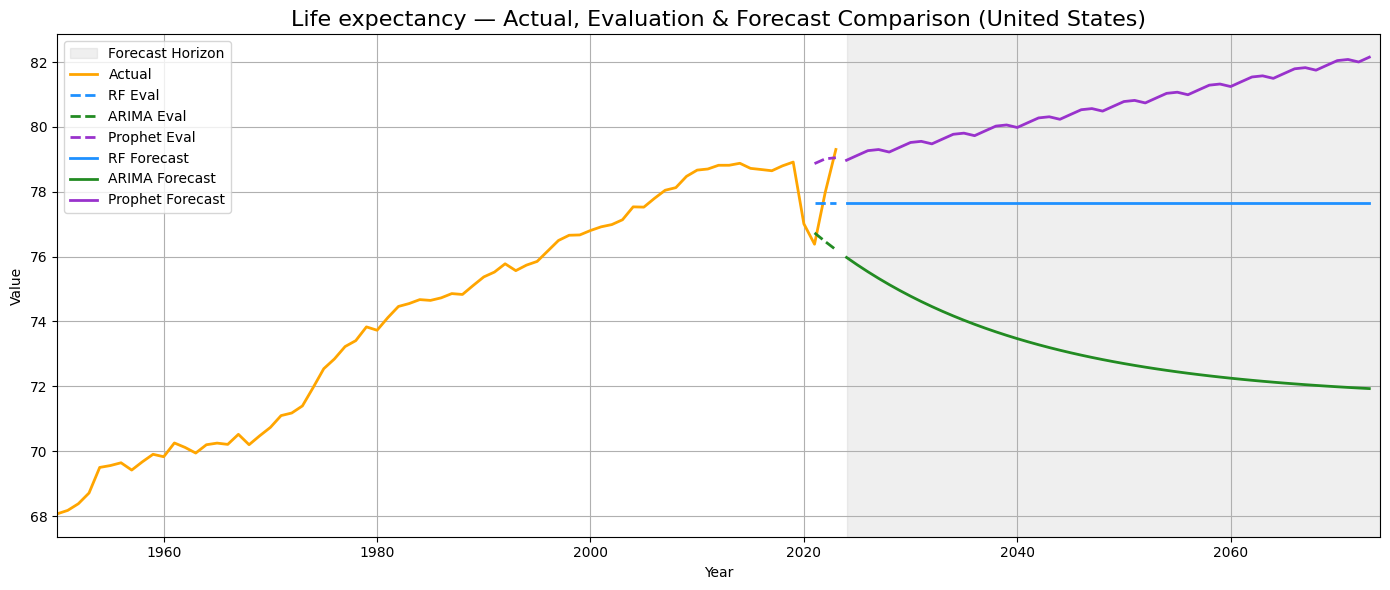

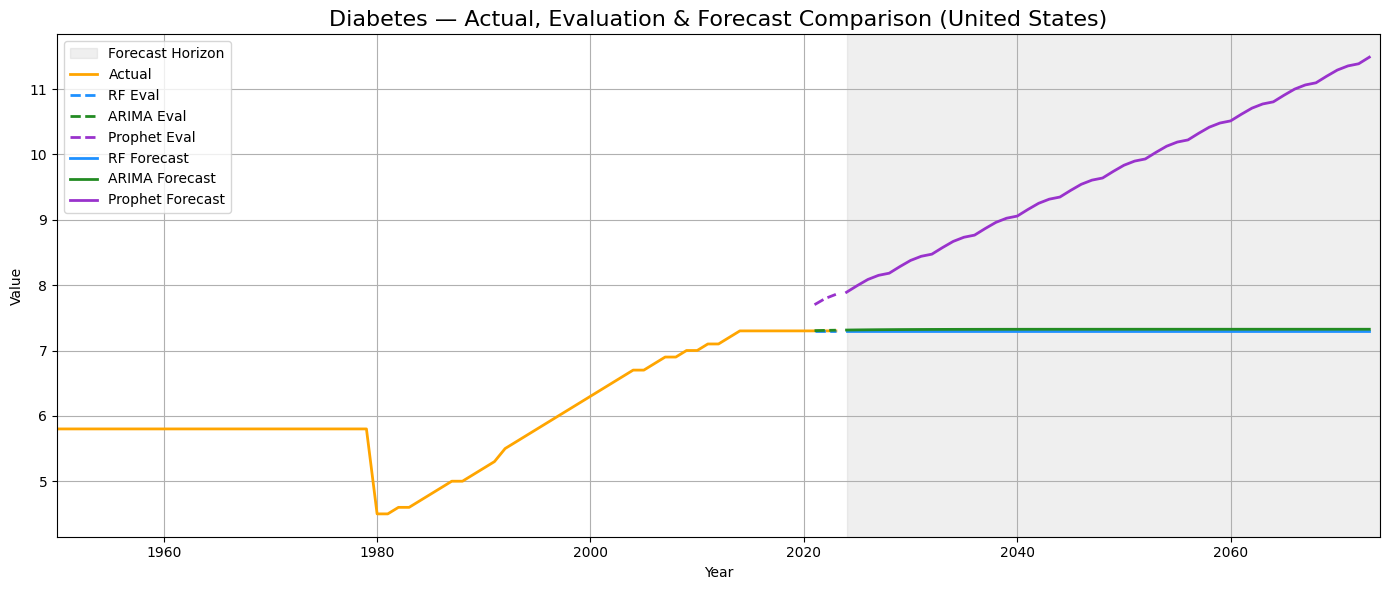

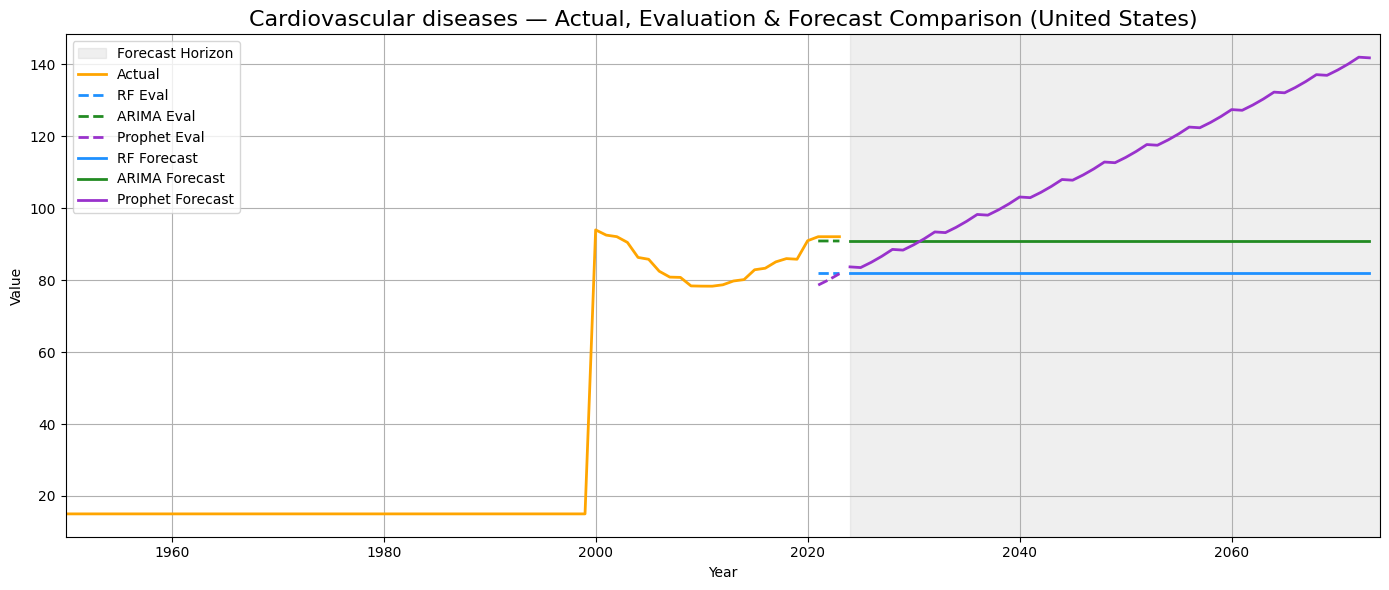

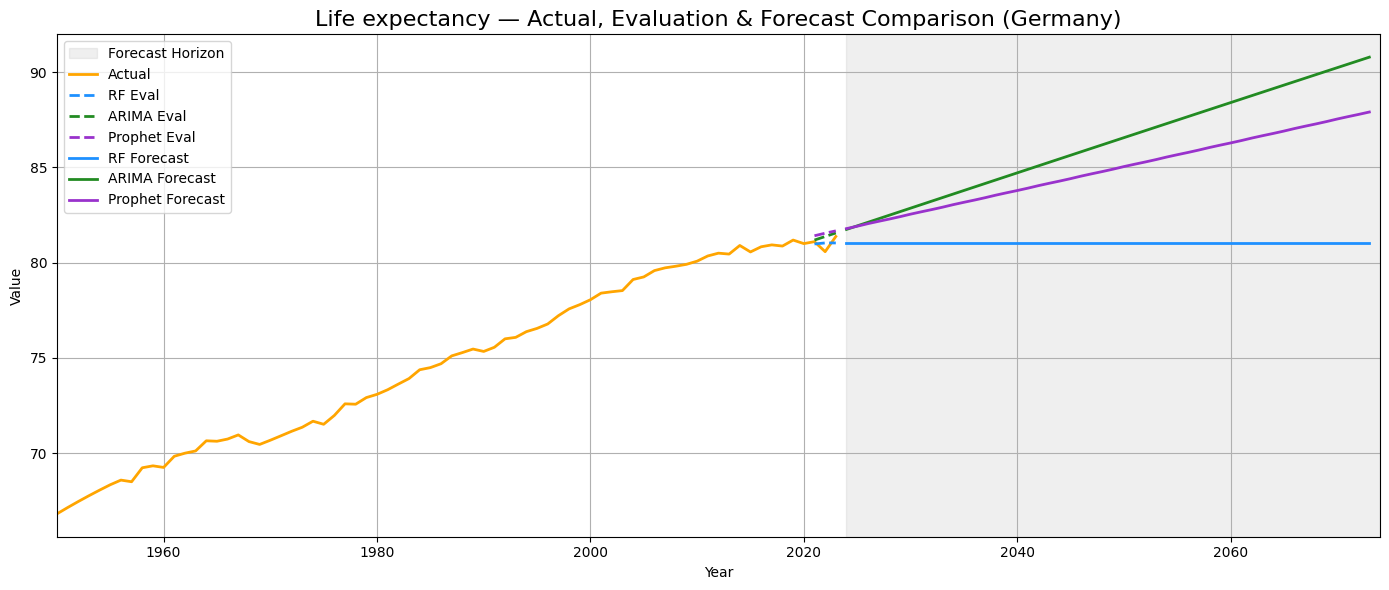

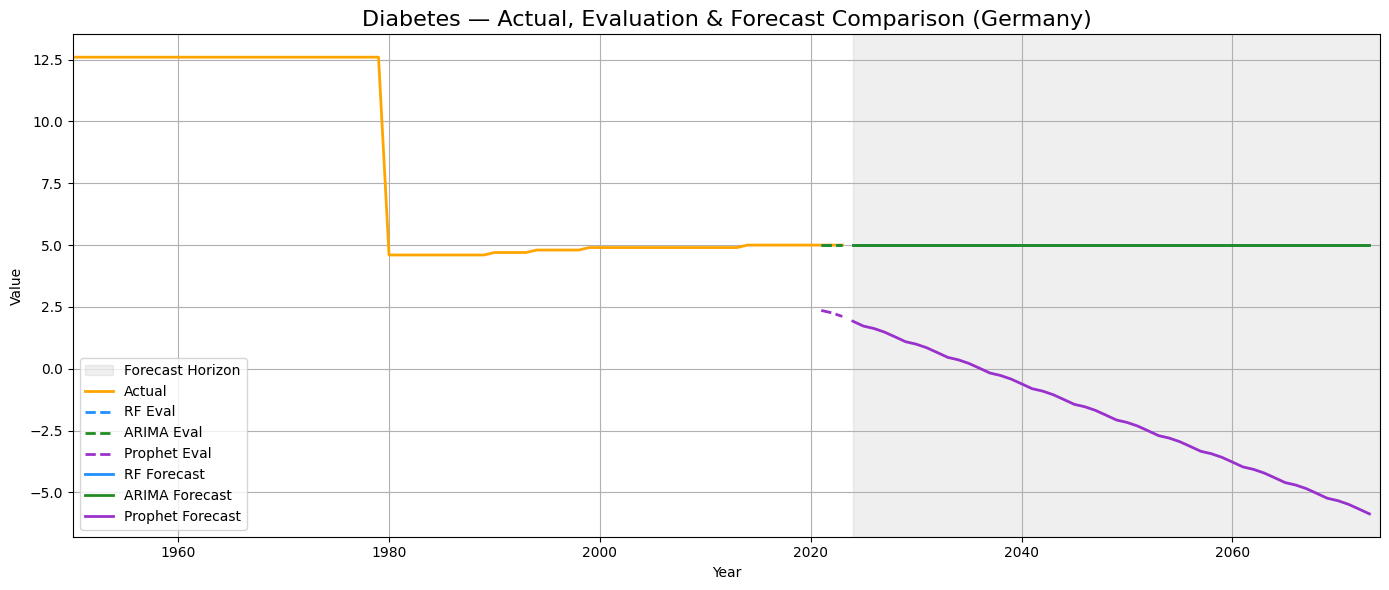

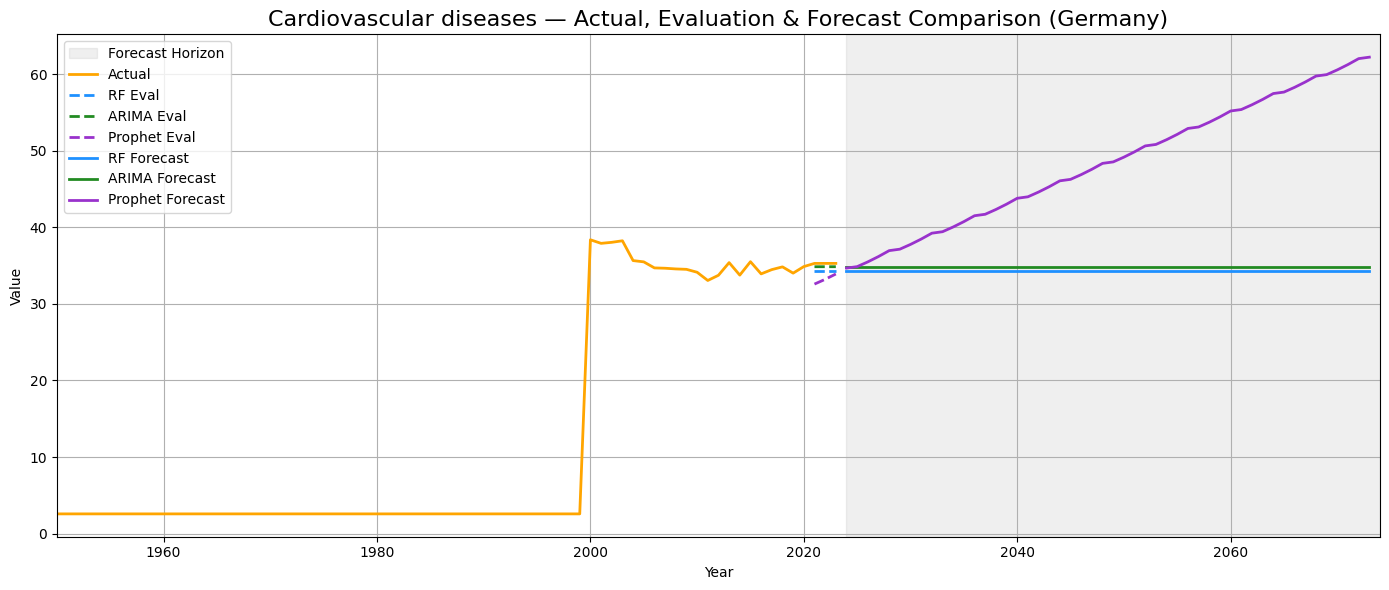

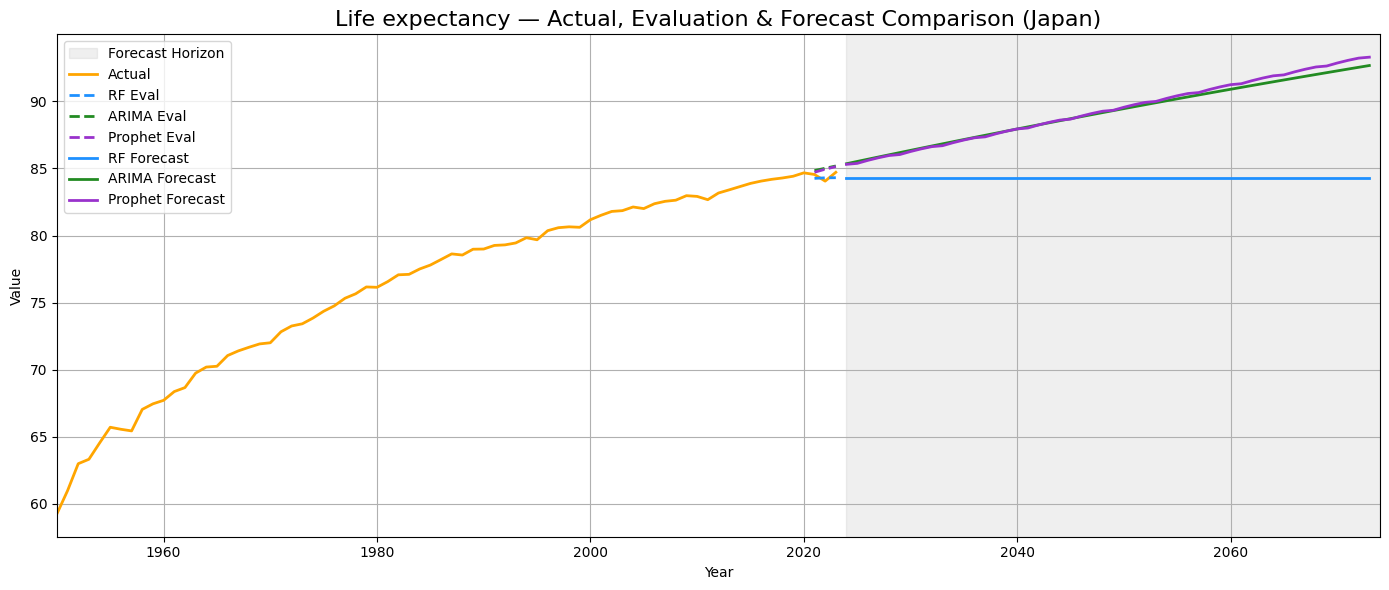

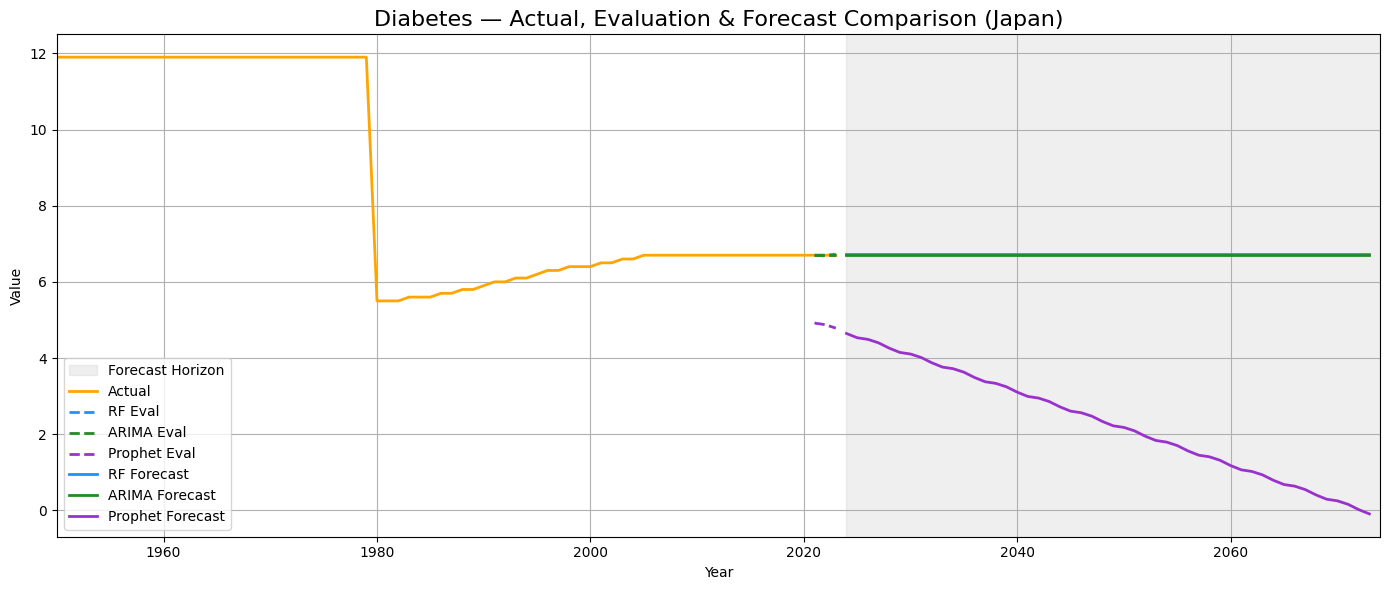

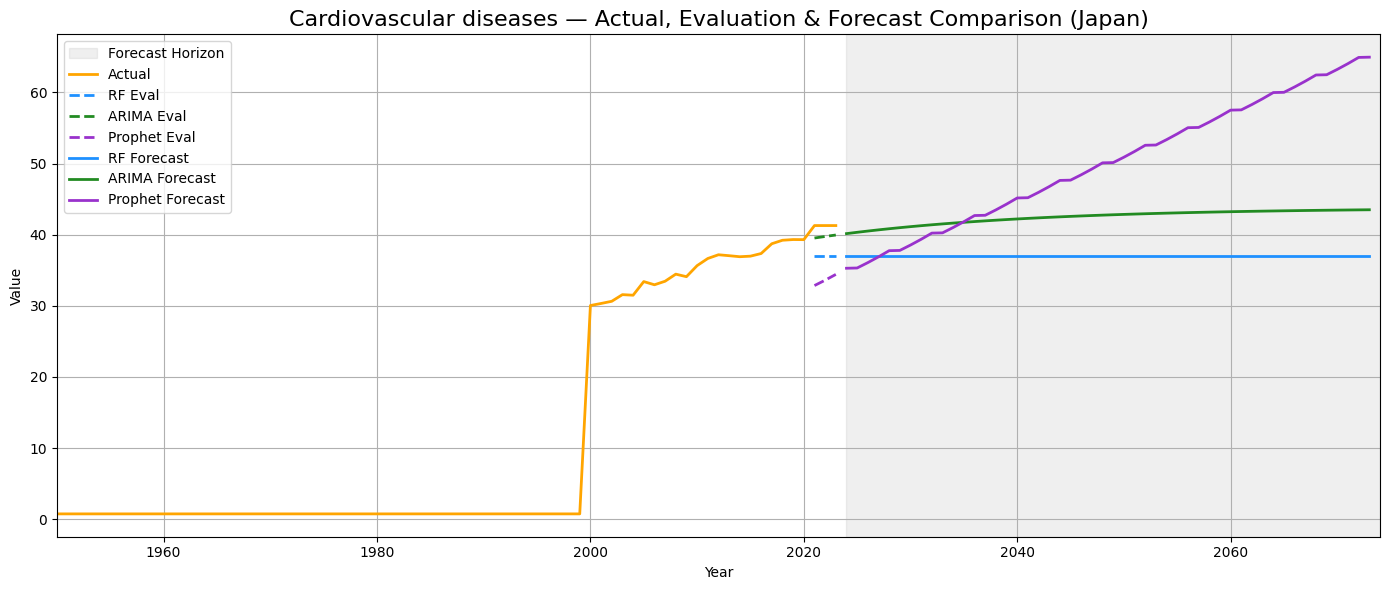

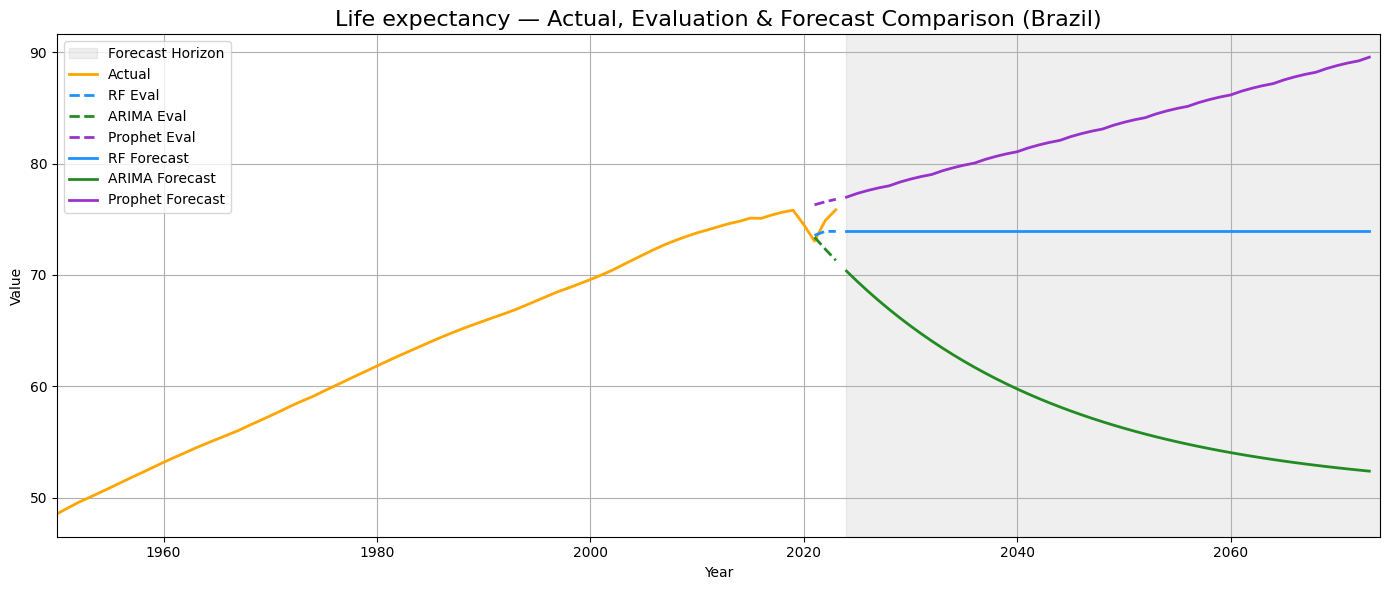

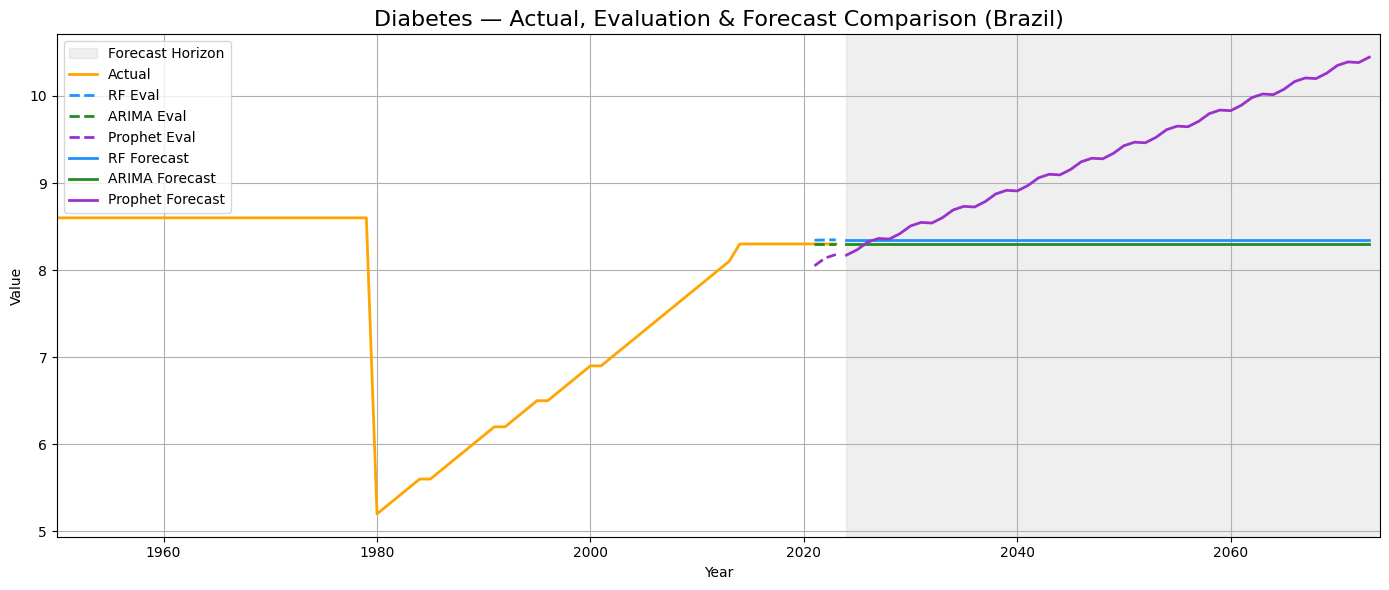

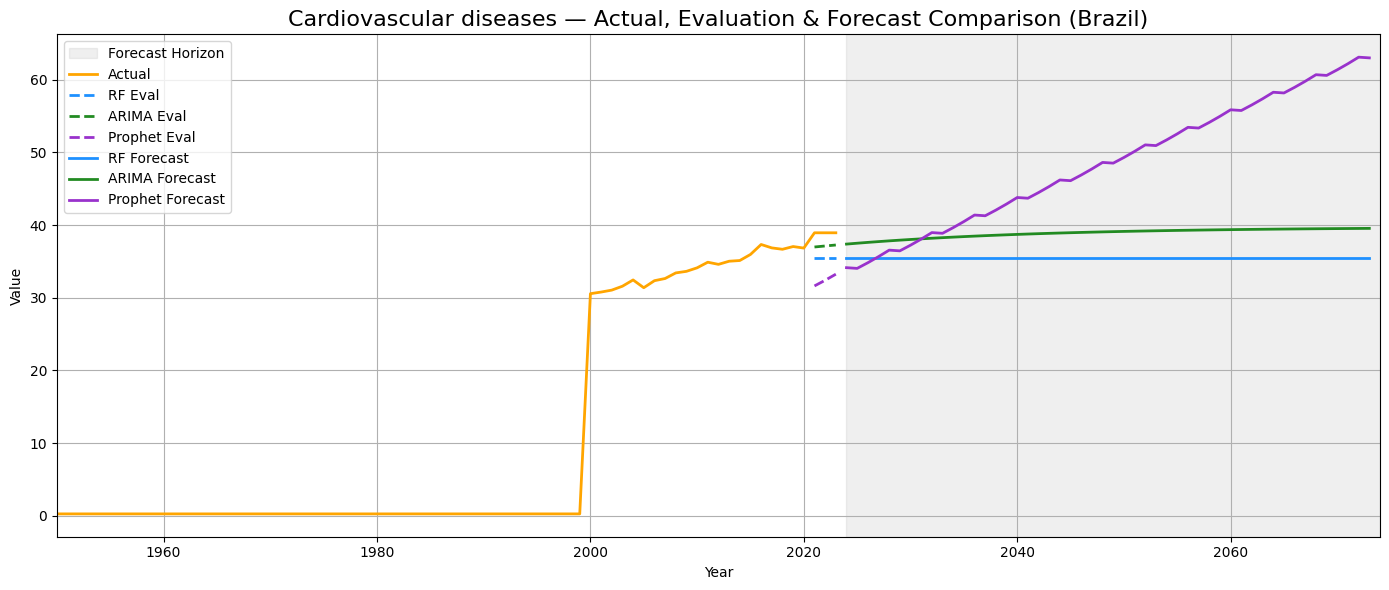

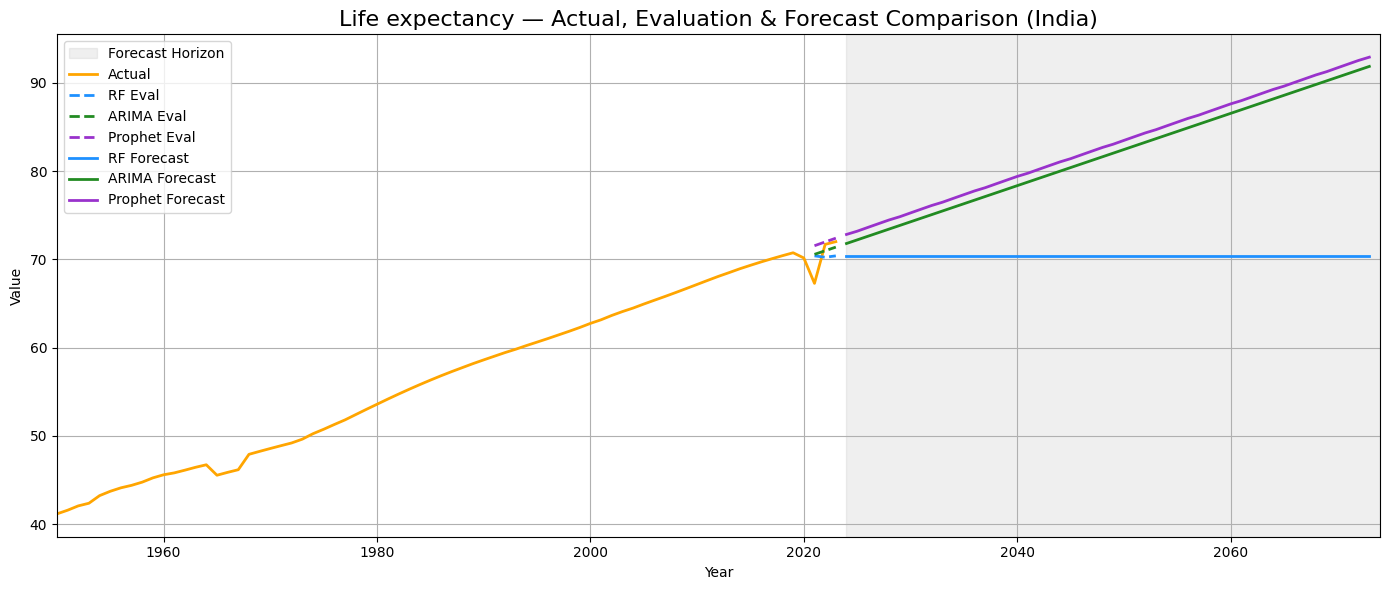

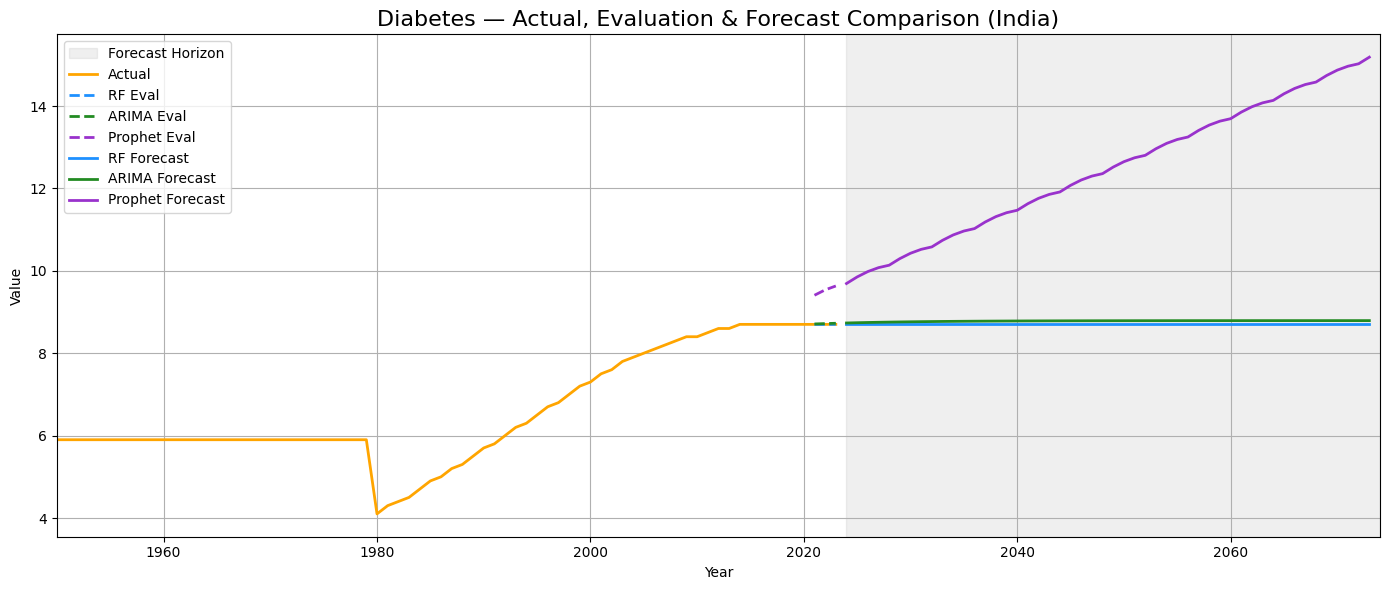

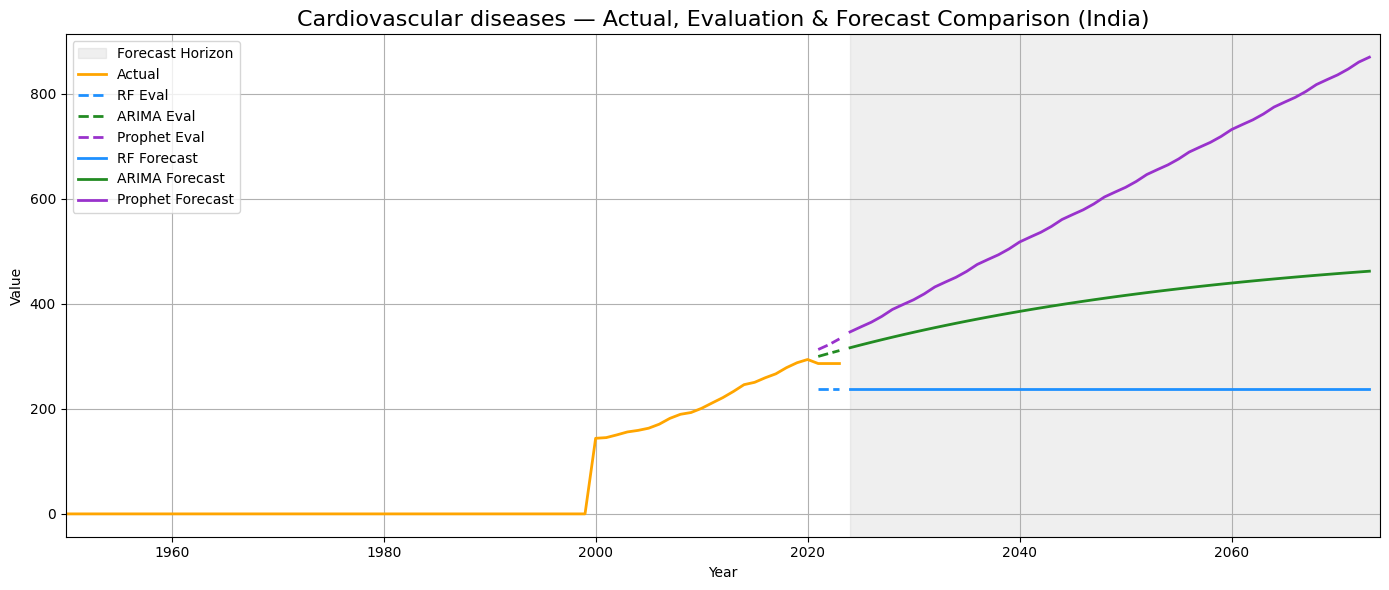

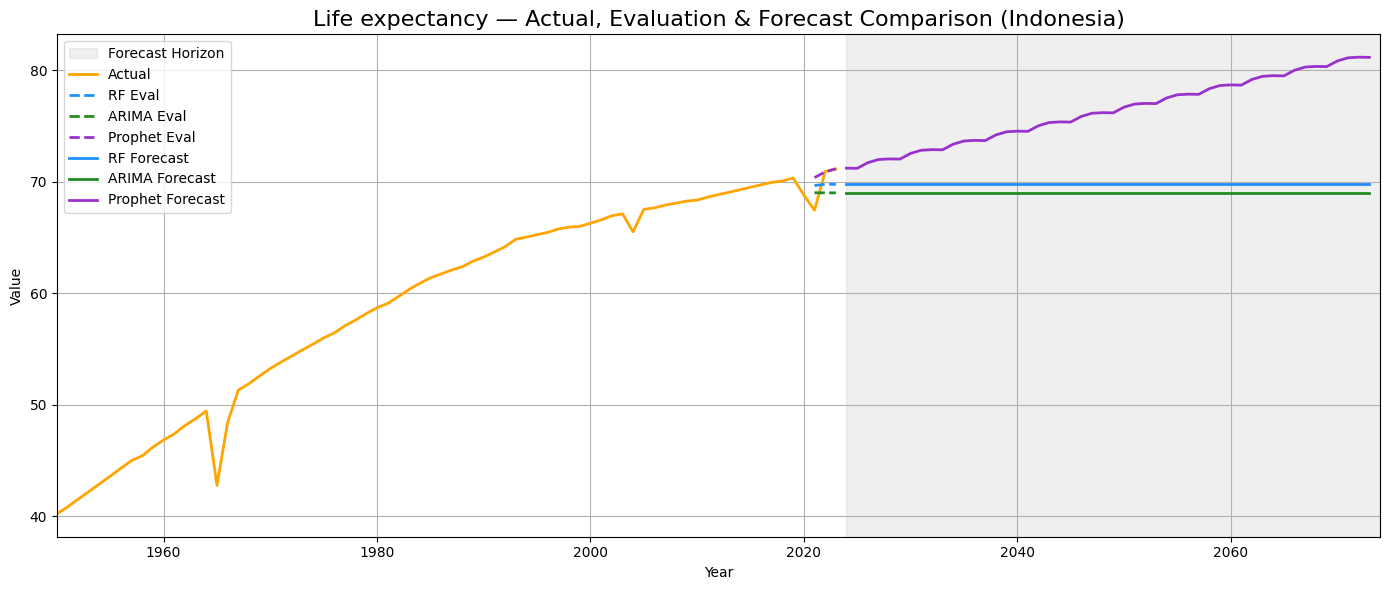

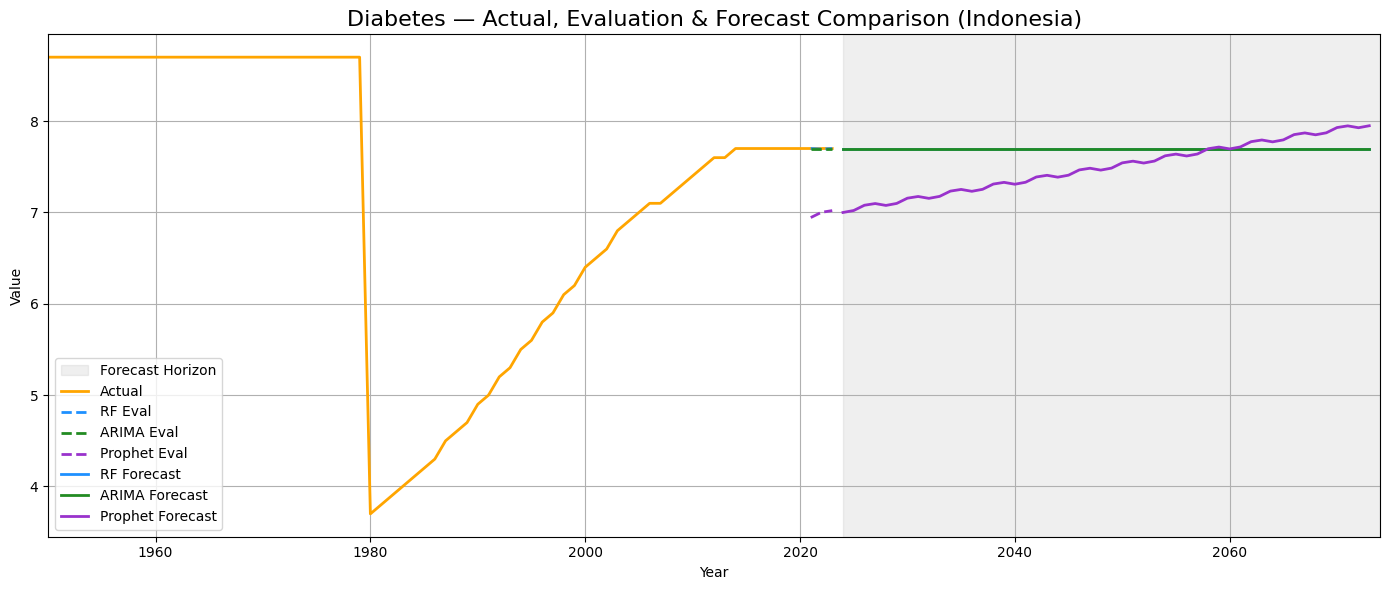

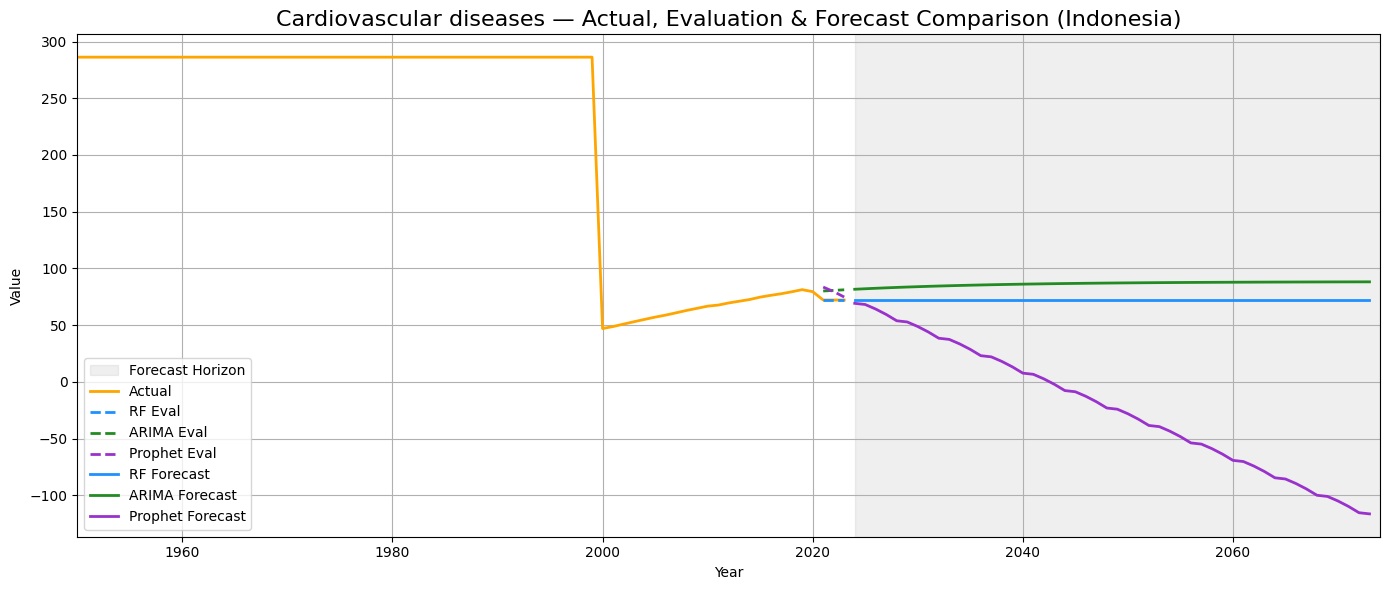

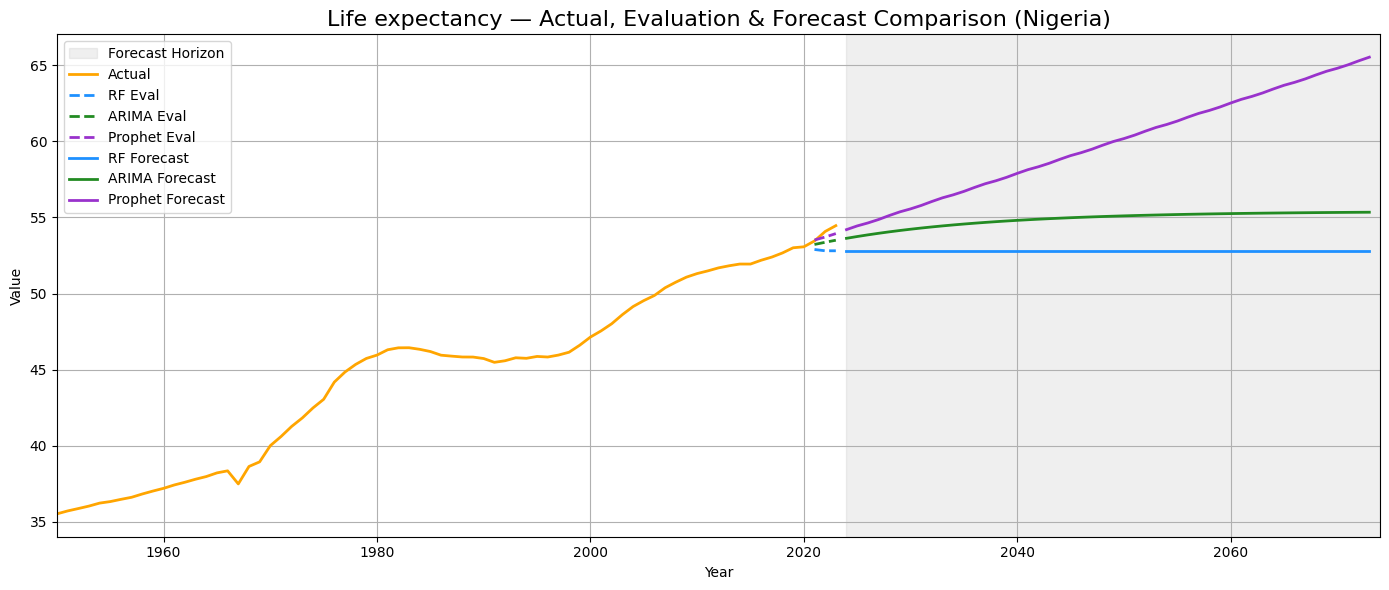

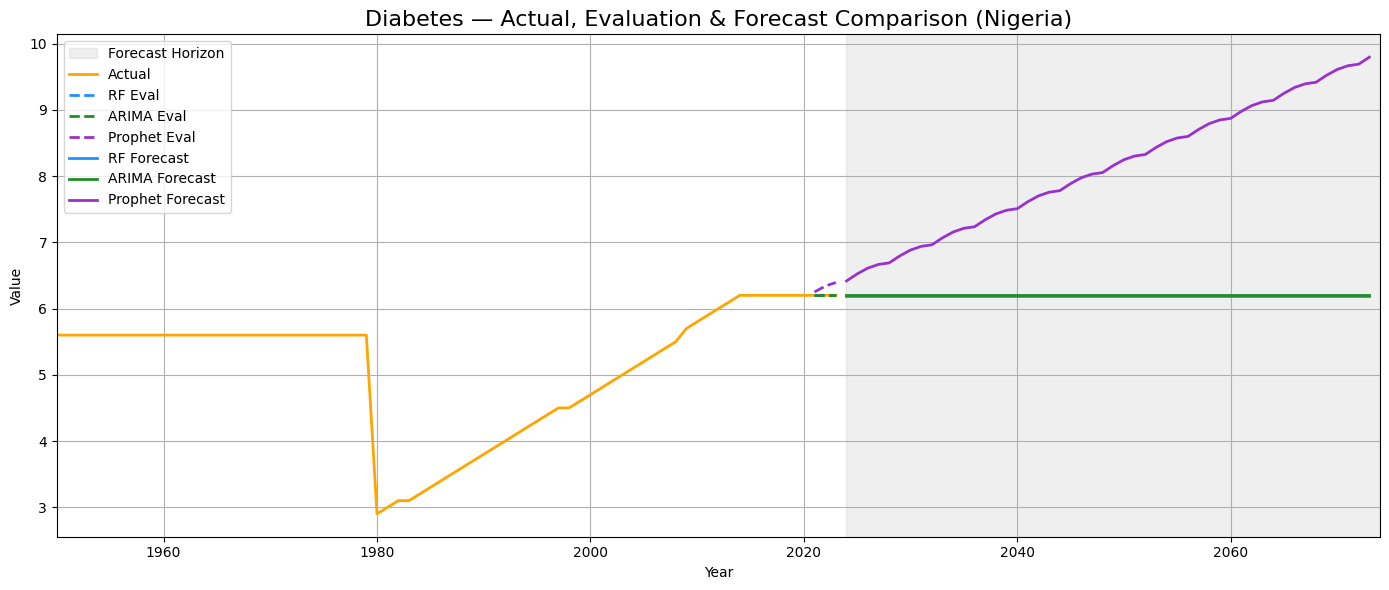

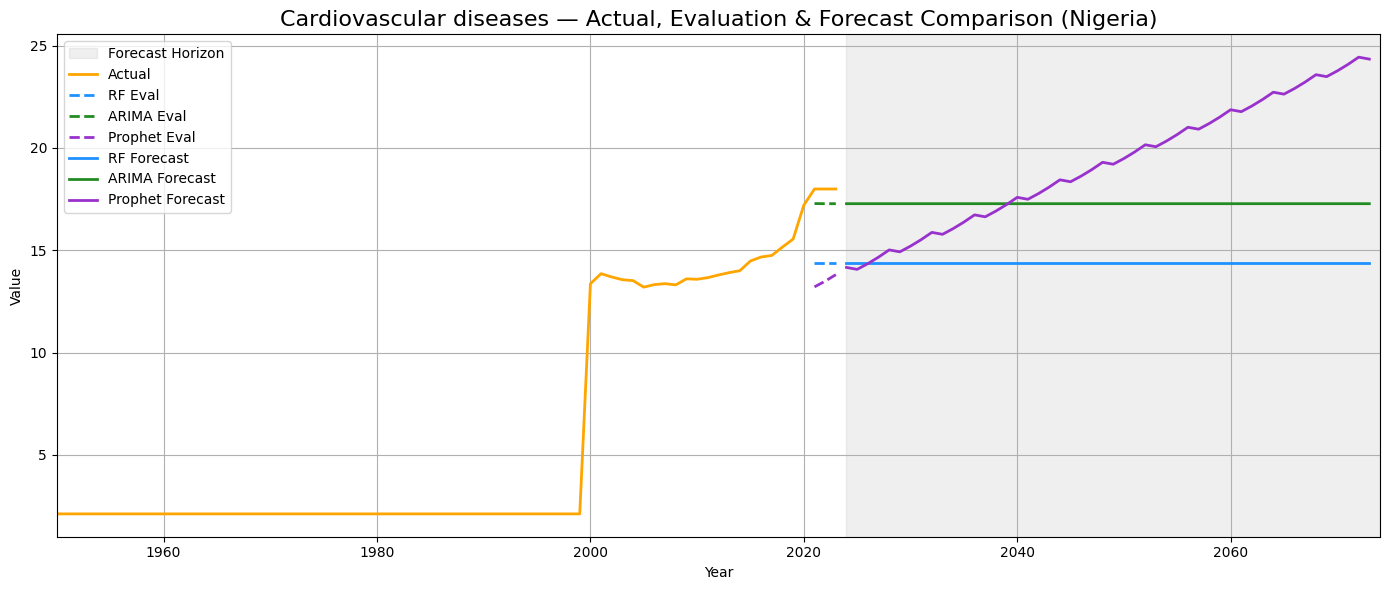

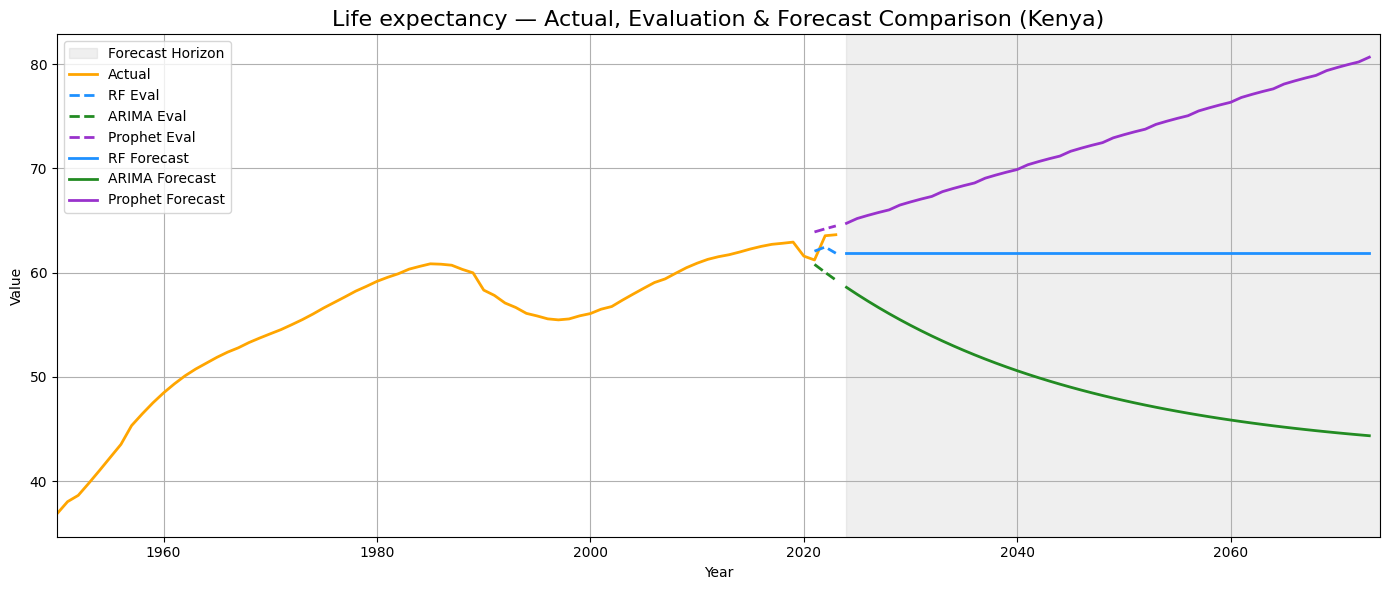

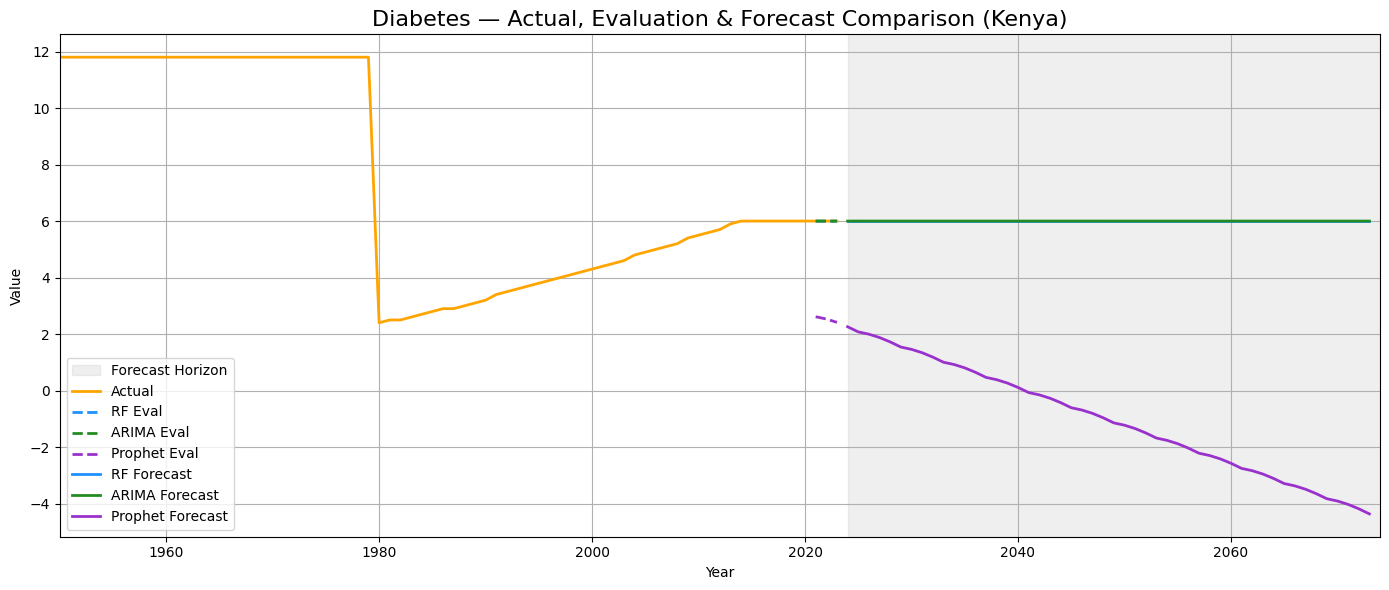

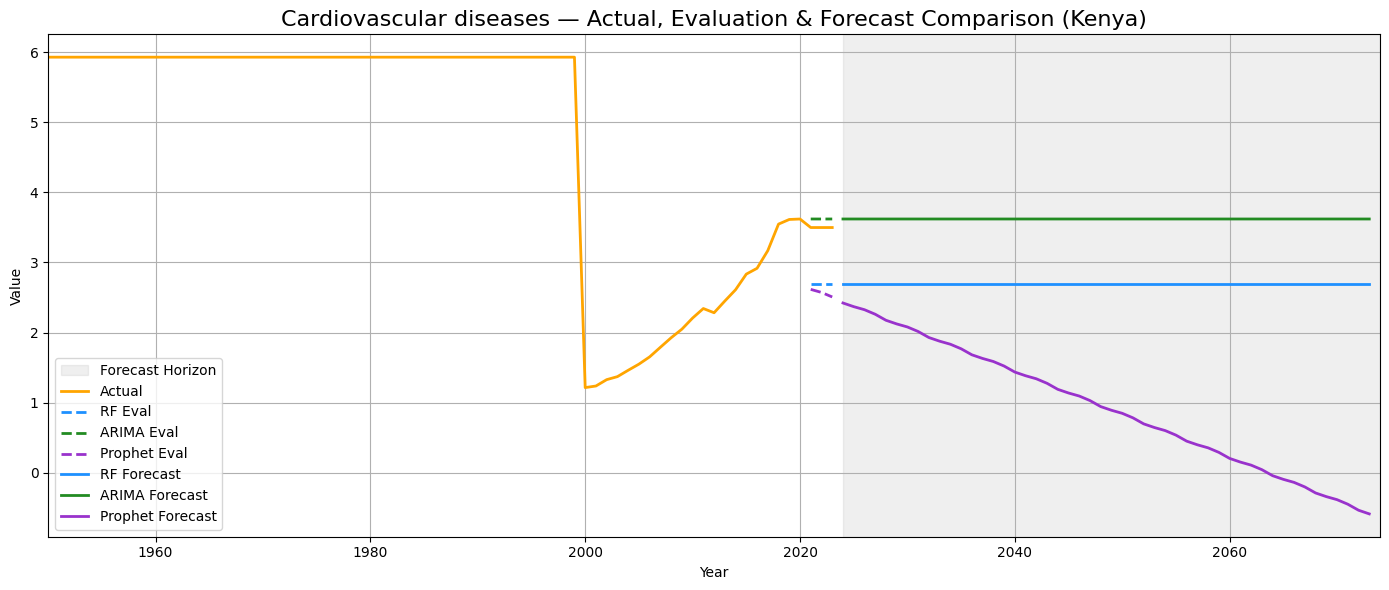

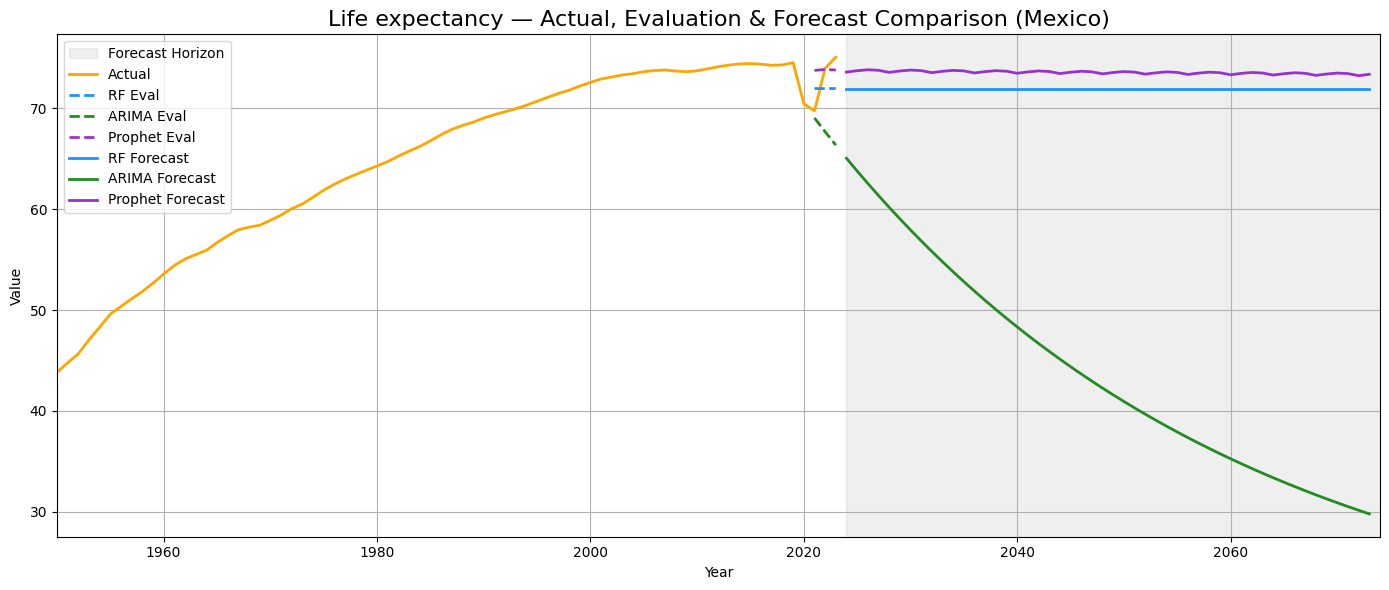

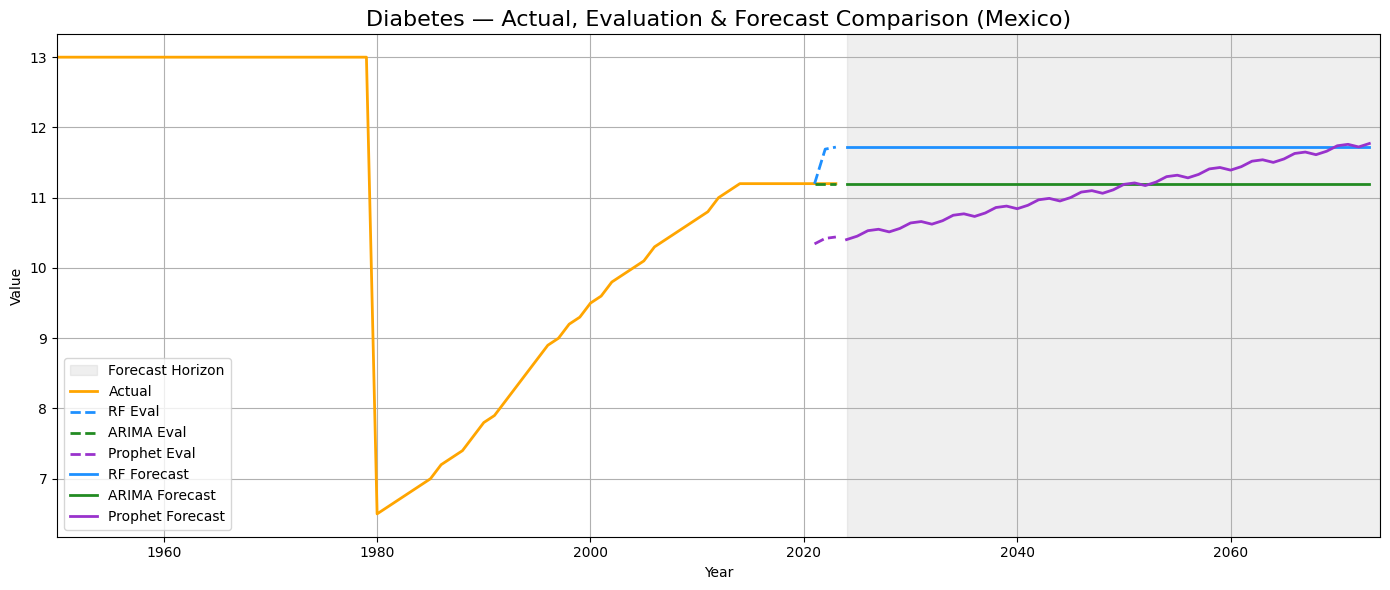

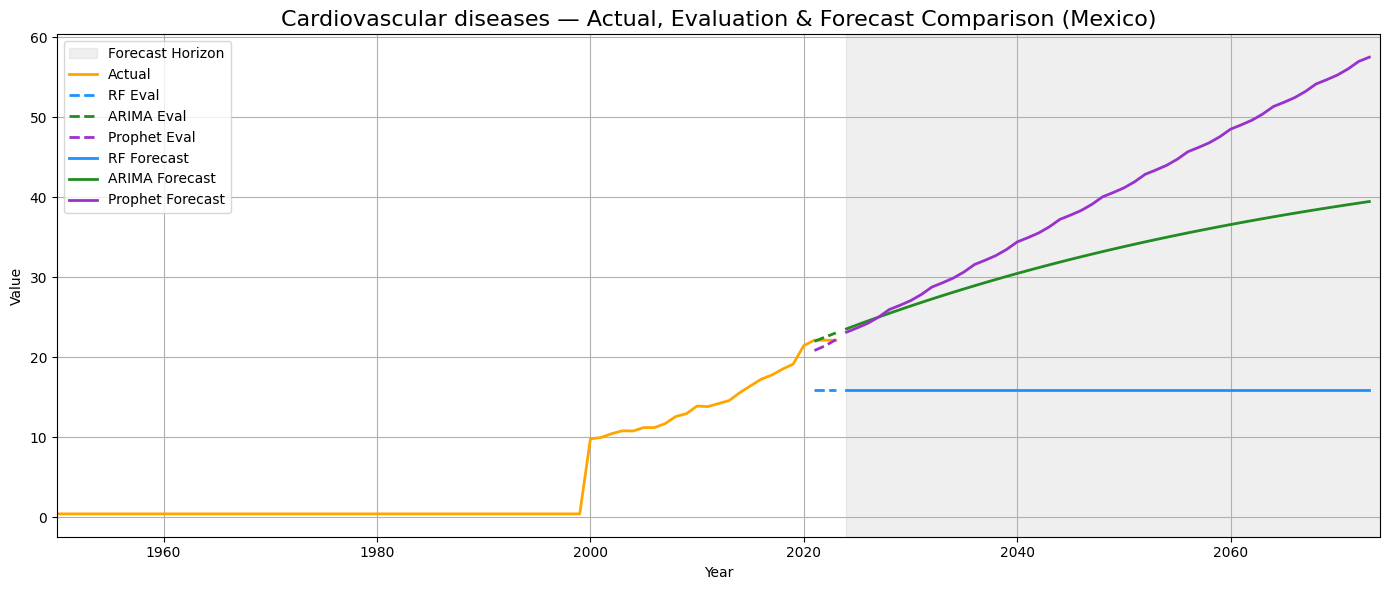

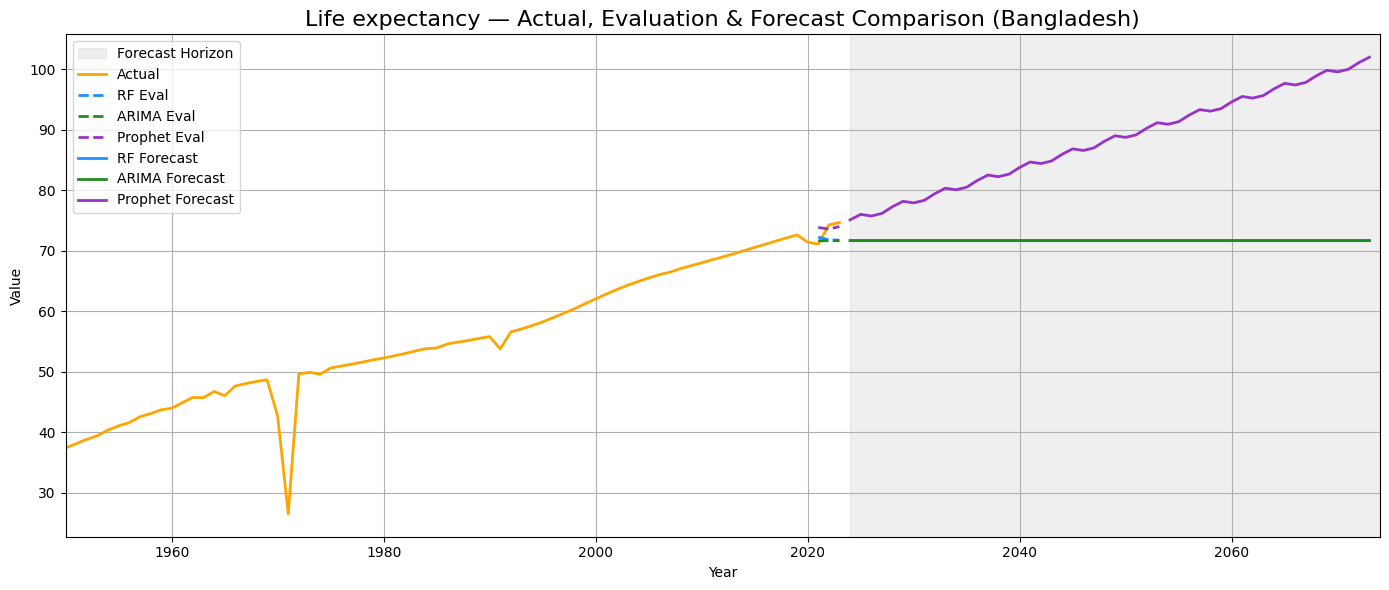

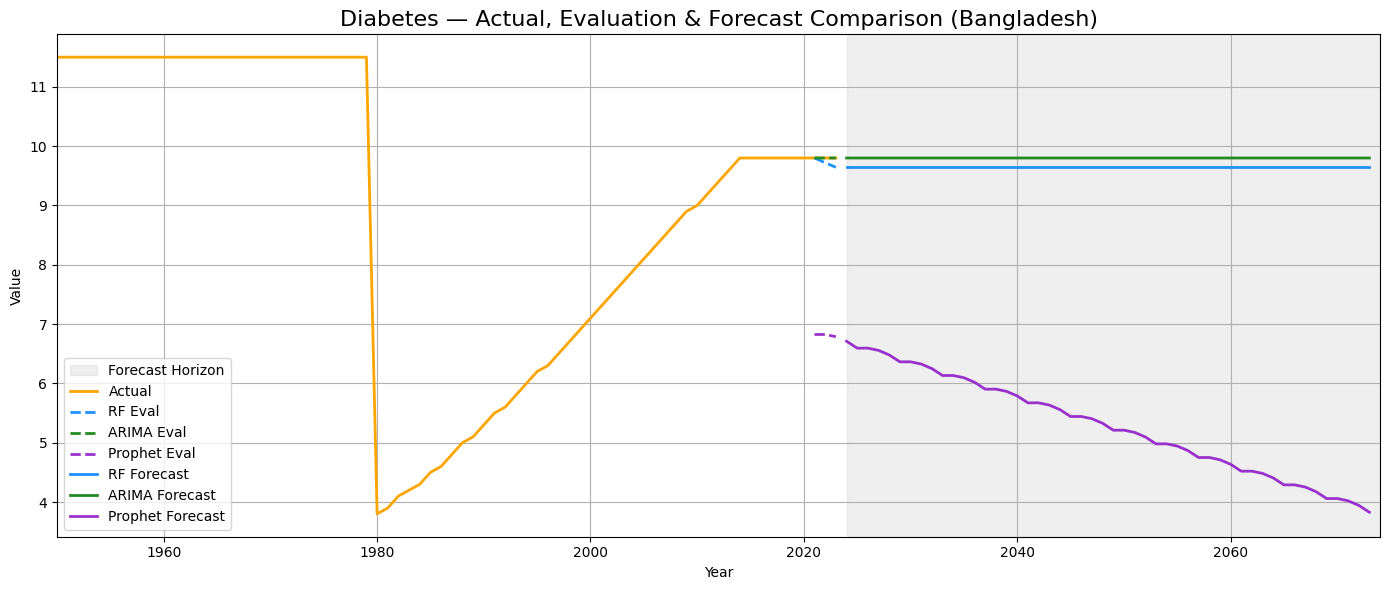

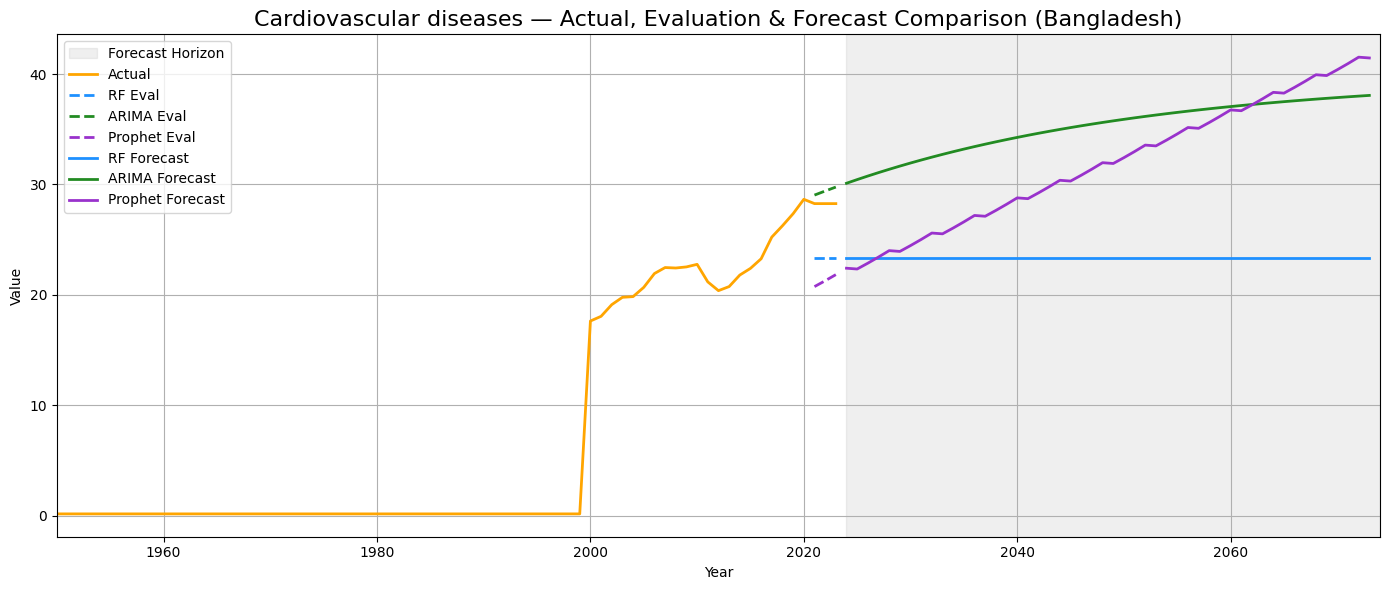

In [ ]:
# plot actual vs predict ARIMA, Prophet, RF

import matplotlib.pyplot as plt
import numpy as np

def plot_target_forecast(df_model_all, df_eval_ready, country, target):
    # Years
    full_years = list(range(1950, 2075))
    eval_years = [2021, 2022, 2023]
    forecast_start, forecast_end = 2024, 2074

    # === Actual values for 1950–2023
    df_actual = df_eval_ready[
        (df_eval_ready['Country'] == country) &
        (df_eval_ready['Year'].between(1950, 2023))
    ].sort_values('Year')
    actual_years = df_actual['Year'].values
    actual_vals = df_actual[target].values

    # === Predictions from df_model_comparison for 2021–2074
    df_pred = df_model_all[
        (df_model_all['Country'] == country) &
        (df_model_all['Target'] == target) &
        (df_model_all['Year'].between(2021, 2074))
    ].sort_values('Year')
    pred_years = df_pred['Year'].values
    rf_vals = df_pred['RF_Forecast'].values
    arima_vals = df_pred['ARIMA_Forecast'].values
    prophet_vals = df_pred['Prophet_Forecast'].values

    # Split prediction into eval + forecast ranges
    rf_eval, rf_forecast = [], []
    arima_eval, arima_forecast = [], []
    prophet_eval, prophet_forecast = [], []

    for yr, rf, ar, pr in zip(pred_years, rf_vals, arima_vals, prophet_vals):
        if yr in eval_years:
            rf_eval.append((yr, rf))
            arima_eval.append((yr, ar))
            prophet_eval.append((yr, pr))
        else:
            rf_forecast.append((yr, rf))
            arima_forecast.append((yr, ar))
            prophet_forecast.append((yr, pr))

    # Begin plot
    plt.figure(figsize=(14, 6))

    # Shaded forecast area
    plt.axvspan(forecast_start, forecast_end, color='gray', alpha=0.12, label="Forecast Horizon")

    # Actual line
    plt.plot(actual_years, actual_vals, label="Actual", color='orange', linewidth=2)

    # Prediction lines (2021–2023)
    if rf_eval: plt.plot(*zip(*rf_eval), label="RF Eval", color='dodgerblue', linestyle='dashed', linewidth=2)
    if arima_eval: plt.plot(*zip(*arima_eval), label="ARIMA Eval", color='forestgreen', linestyle='dashed', linewidth=2)
    if prophet_eval: plt.plot(*zip(*prophet_eval), label="Prophet Eval", color='darkorchid', linestyle='dashed', linewidth=2)

    # Forecast lines (2024–2074)
    if rf_forecast: plt.plot(*zip(*rf_forecast), label="RF Forecast", color='dodgerblue', linewidth=2)
    if arima_forecast: plt.plot(*zip(*arima_forecast), label="ARIMA Forecast", color='forestgreen', linewidth=2)
    if prophet_forecast: plt.plot(*zip(*prophet_forecast), label="Prophet Forecast", color='darkorchid', linewidth=2)

    # Final plot touches
    plt.title(f"{target} — Actual, Evaluation & Forecast Comparison ({country})", fontsize=16)
    plt.xlabel("Year")
    plt.ylabel("Value")
    plt.grid(True)
    plt.legend()
    plt.xlim(1950, 2074)
    plt.tight_layout()
    plt.show()

selected_countries = [
    'United States', 'Germany', 'Japan', 'Brazil', 'India',
    'Indonesia', 'Nigeria', 'Kenya', 'Mexico', 'Bangladesh'
]
selected_targets = ["Life expectancy", "Diabetes", "Cardiovascular diseases"]

for country in selected_countries:
    for target in selected_targets:
        plot_target_forecast(df_model_comparison, df_forecast_ready, country, target)